# Stereo Robot Navigation
### Federico Calzoni, Lorenza Guerriero, Arka Patra

# Index


- [Introduction](#introduction)
- [Objective](#objective)
- [Functional Specifications](#functional-specification)
- [Suggested Improvements](#improvements)
- [Take the dataset](#take-the-dataset)
  * [Load the dataset and the foundamental library](#load-the-dataset-and-the-foundamental-library)
  * [Extracting-image-frames-from-video](#extracting-image-frames-from-video)
- [Stereo Matching Algorithm](#stereo-matching-algorithm)
  * [Preliminary operations](#preliminary-operations)
- [Compute the dense disparity map with CV function](#compute-the-dense-disparity-map-with-cv-function)
  * [Disparity map with StereoBM](#disparity-map-with-stereobm)
  * [Disparity map with StereoSGBM](#disparity-map-with-stereosgbm)
- [Dense Disparity map using custom function](#dense-disparity-map-using-custom-function)
  * [Sum of Absolute Differences (SAD)](#sum-of-absolute-differences-sad)
  * [Sum of Squared Differences (SSD)](#sum-of-squared-differences-ssd) 
  * [Normalized Cross Correlation (NCC)](#normalized-cross-correlation-ncc)
  * [Zero mean Normalized Cross Correlation (ZNCC)](#zero-mean-normalized-cross-correlation-ncc)
    + [Dense Disparity Map with the sequential computation](#dense-disparity-map-with-the-sequential-computation)
    + [Dense Disparity Map with the parallel computation](#dense-disparity-map-with-the-parallel-computation)
- [Distance Estimation](#distance-estimation)
  * [Computing distances during the whole video by using dense disparity maps.](#computing-distances-during-the-whole-video-by-using-dense-disparity-map)
    + [Distance with StereoBM](#distance-with-stereobm)
    + [Distance with StereoSGBM](#distance-with-stereosgbm)
- [Width and Height estimation of the chessboard pattern](#width-and-height-estimation-of-the-chessboard-pattern)
  * [Dimension of the chessboard](#dimension-of-the-chessboard)
- [Improvements](#improvements-1)
  * [1. Distance with customs function and with the offset](#1-distance-with-customs-function-and-with-the-offset)
  * [2. Splitting the image into vertical strips](#2-splitting-the-image-into-vertical-strips)
  * [3. Compute disparity using the salient points](#3-compute-disparity-using-the-salient-points)
- [Results](#results)
- [Video Presentation](#video-presentation)
- [Conclusion](#conclusion)
- [References](#references)


# Introduction <a id="introduction"></a>
Sensing of 3D information related to the obstacles in front of the vehicle should rely on the stereo vision principle. The ability of an autonomous vehicle to sense obstacles and navigate its surroundings is a key role in the development of modern robots. For this reason we present a project in which a robot, through the principle of a stereo camera, is able to perceive the obstacles in front of his view. Such technology could be implemented by a navigation system for autonomous vehicles to automatically avoid obstacles.

# Objective <a id="objective"></a> 
The objective of the project aims to use synchronized video sequences captured by a stereo camera mounted on a moving vehicle to detect spatial information of the frontal environment. The primary task is to develop an area-based stereo matching algorithm capable of generating a dense disparity map from the syncronized stereo camera inputs (robotL.avi for the left view, robotR.avi for the right view). Then by using geometrical calculations an extimated distance from the robot to the central area of the view need to be calculated. Additionally, an alarm is triggered whenever the distance falls below 0.8 meters.
Finally, given that in the center of the sciene there is a chessboard. The dimension of it (height and width) must be computed. This will be useful in order to compare it to the real values and give an extimation of the accuracy of the method used.  


# Functional Specifications <a id="functional-specification"></a>

The system follows a series of steps to achieve its objectives:

1.  <b> Take the dataset</b>\
To estimate all the points, it is useful to take the video and the parameters required to estimate distances from stereo images like focal length (f = 567.2 pixel) and baseline (b = 92.226 mm).

2.  <b>Disparity Map Computation</b>\
Compute the disparity map in a central area of the reference frame to sense distances in the portion of the environment relevant to the vehicle's trajectory.

3.  <b>Main Disparity Estimation</b>\
Estimate the main disparity for the frontal portion of the environment based on the disparity map of the central area of the reference frame.

4.  <b>Distance Calculation</b>\
Determine the distance of the obstacle from the moving vehicle based on the main disparities estimated from each pair of frames.

5.  <b>Output Generation and Alarm Trigger</b>\
Generate output conveying distance information to the user and trigger an alarm when the distance falls below a predefined threshold (0.8 m).

6.  <b>Estimate the size of the board</b>\
Use the found board corners to estimate the size of the board. Then compare it with the real size of the known one (125mm x 178mm)

# Suggested Improvements <a id="improvements"></a>

Several improvement can be followed:

1.  <b>Disparity Map Computation with the offset</b>\
The matching algorithm could be modified to deploy a smaller disparity range with an offset. This offset can be computed knowing the value of the main disparity, dmain, computed at the previous time instant. Accordingly, as the vehicle gets closer to the obstacle, the horizontal offset
increases, thus avoiding the main disparity to exceed the disparity range (and conversely, when the vehicle goes away from the obstacle).

2.  <b>From one disparity to more</b>\
Instead of just a single main disparity, a set of disparities can be computed and associated with the different areas of the obstacle, so to then estimate the distance from the camera for each part of the obstacle. For example, the image may be divided into a 5 large vertical stripes, assuming the vertical lines parallel to the obstacle to be parallel to the image plane of the stereo sensor, and then estimate for each stripe a main disparity value. A planar view of the obstacle could be created by computing the angle between the horizontal lines parallel to the obstacle and the image plane of the stereo sensor.

3.  <b>Develop a more robust approach to estimate the main disparity</b>\
Ambiguous disparity measurements may be detected and removed by analysing the function representing the dissimilarity (similarity) measure along the disparity range or by computing disparities only at sufficiently textured image points. Disiparities could be computed by using the salient image points. 



# Take the dataset <a id="take-the-dataset"></a>
### Load the dataset and the fundamental library <a id="load-the-dataset-and-the-foundamental-library"></a>
The parameters as given in the project 

In [23]:
f = 567.2 # focal length in pixel
b = 92.226 # base line in mm
cb_w = 125 # chessboard total width in  mm
cb_h = 178 # chessboard total height in mm
pattern_size = (6, 8) # number of inner corner, (columns, rows) of chessboard

Importing the required libraries

In [24]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
%matplotlib inline
import numba
from joblib import Parallel, delayed
import warnings
import pickle
import gzip
from math import atan, pi, cos
import gc

### Extracting image frames from video <a id="extracting-image-frames-from-video"></a>

In [25]:
roboL = cv2.VideoCapture('./robotL.avi')
roboL_frames = []

while roboL.isOpened():
    ret, frame = roboL.read()
    if not ret:
        break
    roboL_frames = roboL_frames + [frame]

In [26]:
roboR = cv2.VideoCapture('./robotR.avi')
roboR_frames = []

while roboR.isOpened():
    ret, frame = roboR.read()
    if not ret:
        break
    roboR_frames = roboR_frames + [frame]

In [27]:
print("No. of frames for left camera : ", len(roboL_frames))
print("No. of frames for right camera : ", len(roboR_frames))


number_of_frames = len(roboL_frames)
roboL_frames[10].shape #image dimension


No. of frames for left camera :  389
No. of frames for right camera :  389


(480, 640, 3)

# Stereo Matching Algorithm <a id="stereo-matching-algorithm"></a>

The main objective is to find the disparity value calculated based on the object in the left and right image pairs. Disparity value obtained based on the __differences in the pixel location of particular corresponding features__ recorded in the left and right images. The algorithm could utilizes the Sum of Absolute Differences funcition _(SAD)_, Sum of Squared Differences funcition _(SSD)_, the Normalized Cross Correlation funcition _(NCC)_ or Zero mean Normalized Cross Correlation funcition _(ZNCC)_ for the (dis)similarity  measure to compare intensities between corresponding points in the left and right images.

The matching function can be any function that measures the similarity or the dissimilarity between two different windows within two different images. One window in the current frame and one in the reference frame. _The choice of a suitable matching function is very important._ It impacts both the prediction quality and the computational complexity of the algorithm. The four principal techniques for matching function follow.

## Preliminary operations <a id="preliminary-operations"></a>

In [28]:
warnings.filterwarnings('ignore')

This line of code is used to suppress warning messages that may be generated by Python libraries or modules during program execution. This means that warnings will not be displayed in the output, allowing a more faster execution and a cleaner and less cluttered display of results.

In [29]:
#Convert each frame into a numpy array to perform better mathematical operations
np_L = np.array(roboL_frames)
np_R = np.array(roboR_frames)

To compute the disparity maps, it could be useful to crop the image and focus on the main subject (chessboard in this case). The frame 200 is taken as an example.

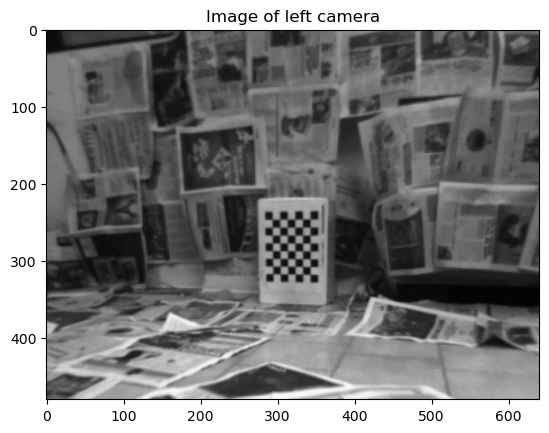

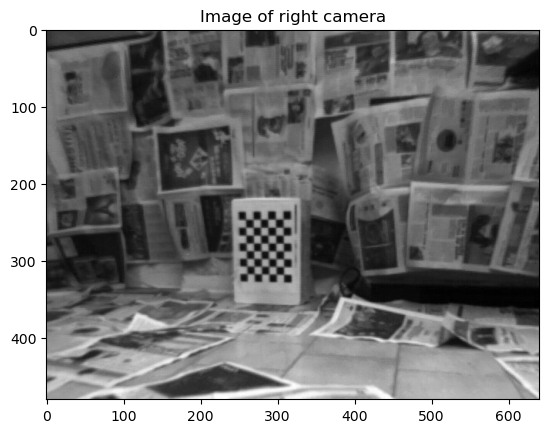

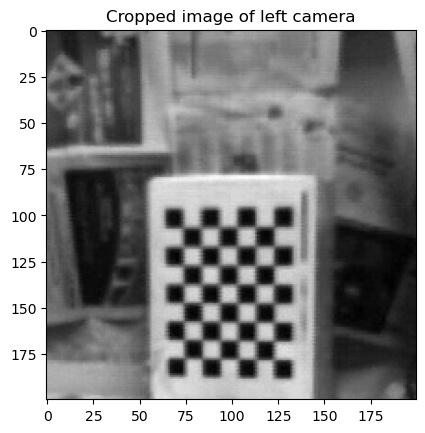

Dimensions:  (200, 200)
Value type:  uint8


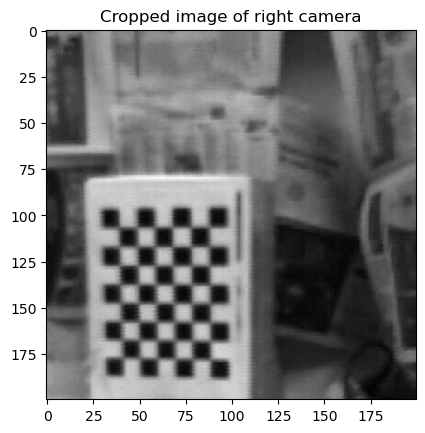

Dimensions:  (200, 200)
Value type:  uint8


In [30]:
#Covert RGB to Gray
np_L_gray = np.array([cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY) for frame in np_L])
np_R_gray = np.array([cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY) for frame in np_R])

framenumber = 200 
Box_size=200
sq_area_side=int(Box_size/2)

Frame_height=np_L_gray.shape[1]
Frame_width=np_L_gray.shape[2]

#crop the images
np_L_cropped=np_L_gray[framenumber,int(Frame_height/2)-sq_area_side:int(Frame_height/2)+sq_area_side,int(Frame_width/2)-sq_area_side:int(Frame_width/2)+sq_area_side]
np_R_cropped=np_R_gray[framenumber,int(Frame_height/2)-sq_area_side:int(Frame_height/2)+sq_area_side,int(Frame_width/2)-sq_area_side:int(Frame_width/2)+sq_area_side]

# Display the images
plt.imshow(np_L_gray[framenumber], cmap='gray')
plt.title(f'Image of left camera')
plt.show()

plt.imshow(np_R_gray[framenumber], cmap='gray')
plt.title(f'Image of right camera')
plt.show()

plt.imshow(np_L_cropped, cmap='gray')
plt.title(f'Cropped image of left camera')
plt.show()
print("Dimensions: ",np_L_cropped.shape)
print("Value type: ",np_L_cropped.dtype)

plt.imshow(np_R_cropped, cmap='gray')
plt.title(f'Cropped image of right camera')
plt.show()
print("Dimensions: ",np_R_cropped.shape)
print("Value type: ",np_R_cropped.dtype)

# Compute the dense disparity map with CV function <a id="compute-the-dense-disparity-map-with-cv-function"></a>

A dense disparity map is a representation of the differences in depth between corresponding points in a pair of stereo images. Stereo images are two images of the same scene taken from slightly different viewpoints, mimicking the way human vision works. By comparing the disparities between corresponding points in these stereo images, you can calculate the depth information of the scene.

In a dense disparity map, _every pixel in one image is matched_ with its corresponding pixel in the other image, and the disparity between them is calculated. This disparity represents how far one pixel has shifted horizontally to find its match in the other image. A dense disparity map contains disparity values for every pixel in the image pair, hence the term __"dense".__

Dense disparity maps are particularly useful in computer vision tasks such as 3D reconstruction, object detection, and scene understanding. They provide detailed depth information that can be used to create 3D models of the scene or to estimate the distances to objects in the images.

Two disparity maps produced using functions from the CV2 library were generated to compare the results with the custom-made disparity map.

## Disparity map with StereoBM <a id="disparity-map-with-stereobm"></a>

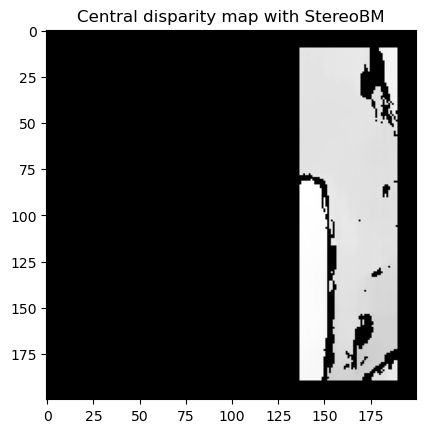

The mean positive disparity: 32.08664840047393


In [31]:
stereo = cv2.StereoBM_create(numDisparities=128, blockSize=21)# numDisparities is the Range of disparity; blockSize is the Size of the window used for matching (odd values only)
disparity = stereo.compute(np_L_cropped,np_R_cropped)

#It is necessary to perform a '/16' conversion to allow for the calculation of pixel disparity between the two images since the output of the function returns a value ranging 
#from -16 to 4064, as it uses 8 bits to describe the disparity for its internal calculations, leaving the last 4 bits null.
disparity=disparity/16
plt.imshow(disparity,'gray')
plt.title (f'Central disparity map with StereoBM')
plt.show()

# Filter out positive disparity values
positive_disparities = disparity[disparity >= 0]
# Calculate mean of positive disparities
mean_disparity = np.mean(positive_disparities)
print("The mean positive disparity:", mean_disparity)

## Disparity map with StereoSGBM <a id="disparity-map-with-stereosgbm"></a>

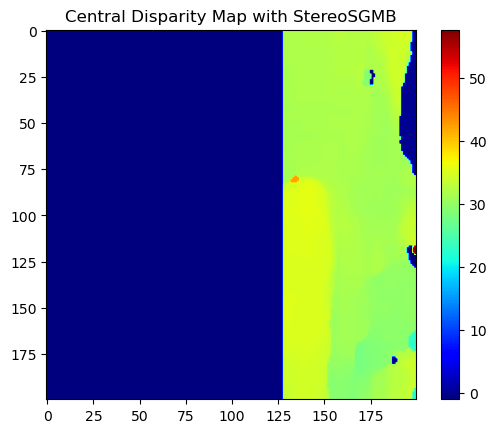

The mean positive disparity is: 32.230320489737124


In [32]:
minDisparity=0          # Minimum possible disparity value
numDisparities=128      # Range of disparity (maxDisparity - minDisparity)
block_size= 21          # Size of the window used for matching (odd values only)
P1=0                    # Penalty for the first pixel disparity difference
P2=0                    # Penalty for the second pixel disparity difference
disp12MaxDiff=0         # Maximum allowed difference in the left-right disparity check
preFilterCap=0          # Maximum allowed difference in the left-right disparity check
uniquenessRatio=0       # Margin in percentage by which the best (minimum) computed cost function value should "win"
speckleWindowSize=0     # Maximum size of smooth disparity regions to consider them as a speckle
speckleRange=0          # Maximum disparity variation within each connected component
mode = 0                # Set it to StereoSGBM::MODE_HH to run the full-scale two-pass dynamic programming algorithm.

stereo = cv2.StereoSGBM_create(minDisparity,numDisparities,block_size,P1,P2,disp12MaxDiff,preFilterCap,uniquenessRatio,speckleWindowSize,speckleRange,mode)
disparity = stereo.compute(np_L_cropped,np_R_cropped)

disparity=disparity/16
positive_disparities = disparity[disparity > 0]
mean_disparity = np.mean(positive_disparities)

plt.imshow(disparity, cmap='jet')
plt.colorbar()
plt.title(f'Central Disparity Map with StereoSGMB')
plt.show()
print('The mean positive disparity is:',mean_disparity)


# Dense Disparity map using custom function <a id="dense-disparity-map-using-custom-function"></a>
In the following sections some popular similarity and dissimilarity funcitions are presented.

### Sum of Absolute Differences (SAD) <a id="sum-of-absolute-differences-sad"></a>

The Sum of Absolute Differences is a __measure of the dissimilarity__ between image blocks. It is calculated by taking the absolute difference between each pixel in the original block and the corresponding pixel in the block being used for comparison.[1]
The SAD may be used for a variety of purposes, such as object recognition, the generation of disparity maps for stereo images, and motion estimation for video compression.

In case of computationt of disparity map it compares intensities between corresponding points in rectified images to compute the disparity map; positive value, indicates that there are differences between the pixels of the two images, the _higher_ the value, the _greater the discrepancy_ between the images; _null_ value, indicates that _there are no differences_ between the pixels of the two images.

SAD takes every pixel in a block. It takes the sum of absolute difference intensity value of the left image and its candidate disparity. 

$$SAD (i,j) = \sum_{m=0}^{M-1} \sum_{n=0}^{N-1} |I(i+m, j+n)-T(m,n)|$$ 
{1}

    I(i+m, j+n)     -intensity value of the image;  
    T(m, n)         -intensity value of target image.        

Both I(i, j) (i.e. the window at position (i, j) of the target image having the same size as T) as well as T can be thought of as M·N-dimensional vectors (flattening). The SAD represents the L1 norm of the difference between vectors I(i,j) e T.

Disparity means the horizontal displacement between the left image and right image. Depth map is also called disparity map.

#### Computation of SAD between two windows in python

In [33]:
@numba.jit #It's used to speed up operations
def sad_fn(L_window, R_window):
    return np.sum(np.abs(L_window - R_window))

### Sum of Squared Differences (SSD) <a id="sum-of-squared-differences-ssd"></a>

The term sum of squares refers to a statistical technique used in regression analysis to determine the dispersion of data points. The sum of squares can be used to find the function that best fits by varying the least from the data. In a regression analysis, the goal is to determine how well a data series can be fitted to a function that might help to explain how the data series was generated. [2]

The sum of squares __measures the deviation of data points__ away from the mean value. The SSD is calculated by adding together the squared differences of each data point. A _higher sum_ of squares indicates _higher variability_ while a _lower result_ indicates _low variability_ from the mean. To calculate the sum of squares, subtract the mean from the data points, square the differences, and add them together. The formula follows:

$$SSD (i,j) = \sum_{m=0}^{M-1} \sum_{n=0}^{N-1} (I (i+m, j+n)-T(m,n))^2$$
{2}

    I(i+m, j+n)     -represent the gray-level values of the image;
    T(m, n)         -represent the gray-level values of the template.

Accordingly, the SSD represents the squared L2 (Euclidean) norm of their difference.

In statistical terms the sum of square, is the measure of the deviation from the mean. It is also known as variation.

#### Computation of SSD between two windows in python

In [34]:
@numba.njit
def ssd_fn(L_window, R_window):
    return np.sum((L_window - R_window)**2)

## Cross correlation <a id="cross-correlation"></a>

Cross-correlation in computer vision is a fundamental technique used for various tasks such as image matching, object detection, template matching, and feature extraction. It involves comparing two images or image patches to measure the similarity between them. Overall, cross-correlation is a versatile tool in computer vision that is used for various tasks ranging from simple template matching to complex feature extraction algorithms.

### Normalized Cross Correlation (NCC) <a id="normalized-cross-correlation-ncc"></a>

Normalized cross-correlation (NCC) is a variant of cross-correlation that accounts for __differences in image intensity and illumination__. It normalizes the cross correlation result to produce values between -1 and 1, where _1 indicates a perfect match, -1 indicates a perfect negative match_, and _values close to 0 indicate low similarity_.

We compute the NCC value between the left and right processed images to measure the similarity of corresponding pixel locations. The aim of this step is to utilize the underlying geometric details [3]. The numerator sums up the product of pixel intensities at corresponding locations in the larger image and the template image, for all possible offsets within the template. The denominator normalizes the numerator by dividing it by the product of the square roots of the sums of squared pixel intensities in the larger image and the template image. The formula is the follows:

$$NCC(i,j)=\frac{\sum_{m=0}^{M-1} \sum_{n=0}^{N-1} I (i+m, j+n)\cdot T(m,n)}{\sqrt{\sum_{m=0}^{M-1} \sum_{n=0}^{N-1} I (i+m, j+n)^2}\cdot \sqrt{\sum_{m=0}^{M-1} \sum_{n=0}^{N-1} T(m,n)^2}} $$
{3}

    I(i+m, j+n)     -represent the gray-level values of the image;
    T(m, n)         -represent the gray-level values of the template.

Exist the _simplified version_ of the Normalized Cross-Correlation (NCC) for the case where \tilde I (i,j) is a constant and T is a vector. Where θ represents the angle between the vector I(i,j) and the vector T. Since the norms of I(i,j) and T cancel out. The NCC represents the cosine of the angle between vectors I(i,j) e T. The formula becomes: 

$$NCC(i,j)=\frac{\tilde I(i,j)\cdot T}{|\tilde I(i,j)|\cdot|T|}=\frac{\tilde I(i,j)\cdot |T| \cdot cos \theta}{|\tilde I(i,j)|\cdot|T|}=cos\theta $$
{4}

Where $$\tilde I(i,j) = \alpha \cdot T$$ is invariant to linear intensity changes.
{5}

The numerator computes the dot product between the vector T and the constant value I(i,j). The denominator normalizes the result by dividing the numerator by the product of the norms of I(i,j) and T.

This __indicates how aligned two vectors__ are with each other: _if θ=0_, then the cosine of θ is 1, _indicating a perfect correlation_; conversely, _if θ=90_, the cosine of θ is 0, _indicating that the vectors are orthogonal and uncorrelated_.

In simpler terms, the formula essentially calculates how similar the template image is to a specific region of the larger image by comparing pixel intensities. It measures the similarity by considering both the intensity values and the spatial relationship between corresponding pixels in the two images. 

#### Computation of NCC between two windows in python

In [35]:
@numba.njit
def ncc_fn(L_window, R_window):
    L_window = L_window/255
    R_window = R_window/255
    return np.sum(L_window * R_window) / (np.sqrt(np.sum(L_window**2)) * np.sqrt(np.sum(R_window**2)))


### Zero mean Normalized Cross Correlation (ZNCC) <a id="zero-mean-normalized-cross-correlation-ncc"></a>

The Zero-mean Normalized Cross-Correlation (ZNCC), is a variation of NCC that takes into account the zero mean property of image windows.
The normalization embodied into the NCC and ZNCC allows for __tolerating linear brightness variations__. Furthermore, thanks to the subtraction of the local mean, the _ZNCC provides better robustness than the NCC_ since it tolerates uniform brightness variations as well. Since template matching based on the ZNCC or NCC can be very expensive, several non-exhaustive algorithms aimed at speeding-up the matching process have been developed. [4] Here's a detailed explanation:

Correlation between T and I at pixel position (i,j) can be written as:

$$ZNCC(i,j)=\frac{\sum_{m=0}^{M-1} \sum_{n=0}^{N-1} (I (i+m, j+n) - \mu (\tilde I)) \cdot (T(m,n)-\mu(T))}{\sqrt{\sum_{m=0}^{M-1} \sum_{n=0}^{N-1} (I (i+m, j+n)-\mu(\tilde I))^2}\cdot \sqrt{\sum_{m=0}^{M-1} \sum_{n=0}^{N-1} (T(m,n)-\mu(T))^2}} $$
{6}

    I(i+m, j+n)     -represent the gray-level values of the image;
    T(m, n)         -represent the gray-level values of the template;
    mu              -the mean intensity value of I and T.

The numerator calculates the sum of the products of pixel differences from the means of the image windows I and T.
The denominator normalizes the numerator by dividing it by the product of the square roots of the sums of squared differences of pixel values from the means of the image windows I and T. This formula compares the similarity between the image windows I and T, taking into account their means and normalizing the result to consider both the similarity of pixel intensities and their relative positions. Like NCC, the result is a value between -1 and 1, where _1 indicates a perfect match_, _-1 indicates a perfect negative match_, and _values close to 0 indicate low or no match_.

#### Computation of ZNCC between two windows in python

In [36]:
@numba.njit
def zncc_fn(L_window, R_window):
    L_window = (L_window - np.mean(L_window))/255
    R_window = (R_window - np.mean(R_window))/255
    return np.sum(L_window * R_window) / (np.sqrt(np.sum(L_window**2)) * np.sqrt(np.sum(R_window**2)))


The following algorithm computes the dense disparity maps, with the previous functions, in two different ways: one sequentially and one parallel. 
Obviously, the parallel approach is much faster than the sequential one.

## Dense Disparity Map with the sequential computation <a id="dense-disparity-map-with-the-sequential-computation"></a>

This code is used to compute the disparity map between two stereo images _using different cost functions_ for measuring the (dis)similarity between corresponding image patches.

The first function 'compute_disparity_cost' computes the cost of disparity between a pixel in the left image and a pixel in the right image. It takes the left image (L_img), the right image (R_img), the y-coordinate of the pixel (pixel_y), the x-coordinate of the pixel in the left image (L_pixel_x), the x-coordinate of the pixel in the right image (R_pixel_x), the cost function (cost_fn), and the crop border size (crop_border) as input.

The second one is 'compute_disparity_map' and this function computes the disparity map for the entire left image. It takes the left image (L_img), the right image (R_img), the maximum disparity (d_max), the block size for computing the disparity (block_size), and the cost function (cost_fn) as input.
The disparity map is initialized with -1 values using np.ones_like (L_img).
Nested loops iterate over the pixels in the left image, excluding borders based on the block size. For each pixel, a search range in the right image is defined based on the maximum disparity (d_max) and the block size.

Within the nested loops, another loop iterates over the search range in the right image. For each pixel in the search range, the cost of disparity is computed using the compute_disparity_cost function. When _ssd_fn and sad_fn cost function are used, the minimum cost and corresponding disparity are updated if the cost is smaller than the current minimum cost_. Instead if _ncc_fn or zncc_fn are used, the maximum cost and corresponding disparity are updated if the cost is bigger than the current maximum cost_.
Finally, the disparity map is updated with the computed disparities.

In [37]:
#This function takes the two windows (one for each image) and gives it to the cost_fn
def compute_disparity_cost(L_img, R_img, pixel_y, L_pixel_x, R_pixel_x, cost_fn, crop_border):
    L_window = L_img[pixel_y-crop_border:pixel_y+crop_border+1, L_pixel_x-crop_border:L_pixel_x+crop_border+1] #We add 1 because the last column and row are exluded 
    R_window = R_img[pixel_y-crop_border:pixel_y+crop_border+1, R_pixel_x-crop_border:R_pixel_x+crop_border+1] #We add 1 because the last column and row are exluded
    cost = cost_fn(L_window, R_window)
    return cost

def compute_disparity_map(L_img, R_img, d_max, block_size, cost_fn):
    disparity = -1*np.ones_like(L_img) #To generate an array of -1 values
    img_hight, img_width = L_img.shape
    crop_border = block_size//2 #The pixels I consider within the neighborhood
    hight_range=range(crop_border,img_hight-crop_border)        
    width_range=range(d_max+crop_border, img_width-crop_border) 
    
    for i in hight_range:
        for j in width_range:
            min_cost = float('inf')
            min_k = 0
            max_cost = 0
            for k in range(j-d_max, j):
                cost = compute_disparity_cost(L_img, R_img, i, j, k, cost_fn, crop_border)
                if (cost_fn == zncc_fn) or (cost_fn == ncc_fn): 
                    if max_cost < cost:
                        max_cost = cost
                        min_k = k
                    if cost == float('inf'):
                        min_k = j+1
                else:      
                    if min_cost > cost:
                        min_cost = cost
                        min_k = k
                    if cost == float('inf'):
                        min_k = j+1

            disparity[i][j] = j-min_k
    return disparity

## Dense Disparity Map with the parallel computation <a id="dense-disparity-map-with-the-parallel-computation"></a>

The initial part of the following code is the same as the previous one. This code is a parallelized version of it. In order to do that a a new function has been defined (compute_disparity_for_pixel). It utilizes parallelization technique to reduce the execution time by computing disparities for many pixels simultaneously. 

The function 'compute_disparity_for_pixel calculates the disparity for a single specific pixel: It takes the pixel coordinates (i, j), the left (L_img) and right (R_img) images, the maximum disparity (d_max), the cost function (cost_fn), the crop border (crop_border), and the minimum disparity (min_disparity) as input. The function iterates over a range of k values within the specified range from j-d_max to j-min_disparity. This range represents the region to search for the pixel correspondence in the right part of the image.
For each k value, the disparity cost is computed using compute_disparity_cost function (like previous). The function returns the disparity and the associated cost for the specific pixel.

The function 'compute_disparity_map_parallel' computes the disparity map for image _using parallelization_. It takes the left (L_img) and right (R_img) images, the maximum disparity (d_max), the block size (block_size), the minimum disparity (min_disparity), and the cost function (cost_fn) as input.
The function initializes the disparity map with -1 values using np.ones_like(L_img), and creates a matrix of cost values initialized to 0 using 0*np.ones_like(L_img, dtype=np.float64). Iteration ranges for the height and width of the left image are defined, excluding the borders based on the block size.
Using the Parallel module from the joblib library, parallel computation of disparity is performed for all pixels in the specified range.
The obtained results are stored in a list of tuples containing the disparity and the associated cost.

Finally, the results are rearranged into the disparity map and the cost value matrix using the computed indices returned by the compute_disparity_for_pixel function.

In [38]:
def compute_disparity_cost(L_img, R_img, pixel_y, L_pixel_x, R_pixel_x, cost_fn,crop_border):
    L_window = L_img[pixel_y-crop_border:pixel_y+crop_border+1, L_pixel_x-crop_border:L_pixel_x+crop_border+1]
    R_window = R_img[pixel_y-crop_border:pixel_y+crop_border+1, R_pixel_x-crop_border:R_pixel_x+crop_border+1]
    return cost_fn(L_window, R_window)

def compute_disparity_for_pixel(i, j, L_img, R_img, d_max, cost_fn, crop_border, min_disparity):
    min_cost = np.inf
    max_cost = -np.inf
    min_k = 0
    for k in range(j-d_max, j-min_disparity):
        cost = compute_disparity_cost(L_img, R_img, i, j, k, cost_fn, crop_border)
        if (cost_fn == zncc_fn) or (cost_fn == ncc_fn): 
            if max_cost < cost:
                max_cost = cost
                min_k = k
            if cost == np.inf:
                min_k = j+1
        else: 
            if min_cost > cost:
                min_cost = cost
                min_k = k
            if cost == np.inf:
                min_k = j+1
    return j-min_k, cost

def compute_disparity_map_parallel(L_img, R_img, d_max, block_size, min_disparity, cost_fn):
    img_hight, img_width = L_img.shape   
    crop_border = block_size//2    
    hight_range=range(crop_border,img_hight-crop_border)
    width_range=range(d_max+crop_border+min_disparity, img_width-crop_border)

    disparity = -1*np.ones_like(L_img)
    cost_values = -2*np.ones_like(L_img, dtype=np.float64)
    
    results = Parallel(n_jobs=-1)(delayed(compute_disparity_for_pixel)(i, j, L_img, R_img, d_max, cost_fn, crop_border, min_disparity) for i in hight_range for j in width_range)

    for idx, result in enumerate(results):
        i = hight_range[idx // len(width_range)]
        j = width_range[idx % len(width_range)]
        disparity[i][j], cost_values[i][j] = result
    return disparity, cost_values


# Distance Estimation <a id="distance-estimation"></a>

Based on the computed disparity map, the system estimates the main disparity for the frontal portion of the environment. Using the provided parameters (focal length and baseline), it calculates the distance (in mm) of obstacles from the moving vehicle.

$$ Z(mm)=\frac {f(pixel)\cdot b(mm)}{d(pixel)}$$
{7}

    z       -Depth 
    f       -Focal length of the camera 
    b       -Distance between the camera centers (base line)
    d       -Mean Disparity 

This formula represents the calculation of the _distance Z in millimeters using the standard stereo geometry_. The depth is directly proportional to the focal length of the camera and the horizontal displacement. The formula is based on the principle of triangulation, which is commonly used in stereo cameras to calculate the distance of objects from the camera. Disparity (d) is the difference between the x coordinates of corresponding points in the left and right images. Focal length f is an intrinsic parameter of the camera, while baseline distance b is the physical distance between the two cameras.

In general, this formula is used in computer vision to calculate the _distances of objects from a stereo camera_ using the disparity of corresponding points in the two images. This is useful for applications such as depth estimation, object recognition, and autonomous navigation.



## Computing distances during the whole video by using dense disparity maps. <a id="computing-distances-during-the-whole-video-by-using-dense-disparity-map"></a>
##### 1.  Distance with StereoBM <a id="distance-with-stereobm"></a>

Mean disparity (d_mean) for each frame:
0: 20.47
1: 20.48
2: 20.46
3: 20.46
4: 20.5
5: 20.46
6: 20.48
7: 20.45
8: 20.44
9: 20.48
10: 20.46
11: 20.48
12: 20.55
13: 20.53
14: 20.67
15: 20.79
16: 20.84
17: 20.83
18: 20.95
19: 21.03
20: 21.12
21: 21.19
22: 21.2
23: 21.23
24: 21.41
25: 21.51
26: 21.5
27: 21.48
28: 21.39
29: 21.48
30: 21.46
31: 21.52
32: 21.53
33: 21.52
34: 21.48
35: 21.4
36: 21.46
37: 21.46
38: 21.53
39: 21.75
40: 21.84
41: 22.09
42: 22.29
43: 22.71
44: 22.83
45: 22.97
46: 23.11
47: 23.39
48: 23.68
49: 23.89
50: 24.12
51: 24.25
52: 24.39
53: 24.64
54: 24.69
55: 24.82
56: 24.92
57: 25.06
58: 25.26
59: 25.44
60: 25.51
61: 25.76
62: 25.92
63: 26.07
64: 26.24
65: 26.37
66: 26.53
67: 26.71
68: 26.82
69: 27.08
70: 27.26
71: 27.49
72: 27.66
73: 28.05
74: 28.31
75: 28.46
76: 28.69
77: 28.85
78: 29.09
79: 29.29
80: 29.56
81: 29.73
82: 30.06
83: 30.22
84: 30.57
85: 30.96
86: 31.02
87: 31.63
88: 31.77
89: 31.97
90: 32.27
91: 32.46
92: 32.82
93: 33.02
94: 33.29
95: 33.64
96: 34.05
97: 

290: 56.09
291: 58.8
292: 61.04
293: 61.78
294: 63.94
295: 67.66
296: 70.58
297: 72.47
298: 75.45
299: 81.34
300: 82.3
301: 90.35
302: 89.23
303: 94.02
304: 99.99
305: 101.71
306: 103.01
307: 105.15
308: 106.32
309: 106.08
310: 104.46
311: 102.09
312: 102.11
313: 95.35
314: 92.93
315: 83.63
316: 78.24
317: 73.48
318: 66.94
319: 63.45
320: 61.45
321: 59.27
322: 57.52
323: 55.96
324: 54.39
325: 52.07
326: 50.53
327: 48.88
328: 47.81
329: 47.25
330: 47.54
331: 46.71
332: 44.92
333: 43.74
334: 42.88
335: 42.11
336: 41.62
337: 40.83
338: 40.57
339: 40.67
340: 40.27
341: 39.9
342: 39.37
343: 38.44
344: 37.7
345: 37.07
346: 36.09
347: 35.25
348: 35.58
349: 35.21
350: 34.42
351: 34.04
352: 33.77
353: 33.6
354: 33.3
355: 33.0
356: 32.51
357: 32.05
358: 31.62
359: 31.4
360: 30.9
361: 30.4
362: 30.01
363: 29.44
364: 28.94
365: 28.54
366: 28.22
367: 27.89
368: 27.61
369: 27.37
370: 27.07
371: 26.73
372: 26.36
373: 26.43
374: 26.47
375: 25.9
376: 25.84
377: 25.24
378: 25.08
379: 25.03
380: 25.12
38

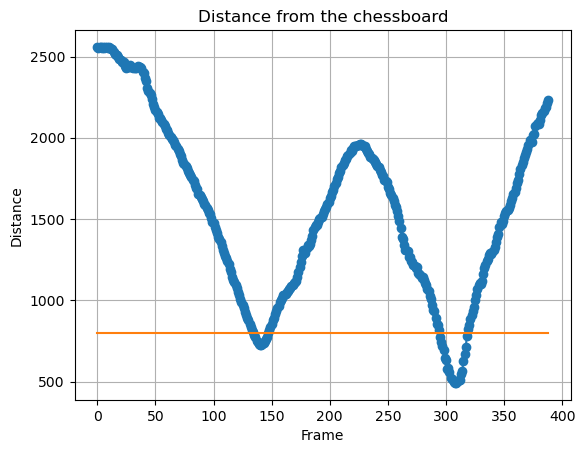

In [39]:
# Store the cropped images in 2 lists

list_L_cropped = []
list_R_cropped = []

Box_size=200
sq_area_side=int(Box_size/2)

Frame_height=np_L_gray.shape[1]
Frame_width=np_L_gray.shape[2]

for framenumber in range(number_of_frames):
    np_L_cropped=np_L_gray[framenumber,int(Frame_height/2)-sq_area_side:int(Frame_height/2)+sq_area_side,int(Frame_width/2)-sq_area_side:int(Frame_width/2)+sq_area_side]
    np_R_cropped=np_R_gray[framenumber,int(Frame_height/2)-sq_area_side:int(Frame_height/2)+sq_area_side,int(Frame_width/2)-sq_area_side:int(Frame_width/2)+sq_area_side]
    list_L_cropped.append(np_L_cropped)
    list_R_cropped.append(np_R_cropped)

list_mean_disparity = []
disparity_map_list_BM = []

numDisparities=128
block_size=17

stereo = cv2.StereoBM_create(numDisparities, block_size)

print("Mean disparity (d_mean) for each frame:")
for framenumber in range(number_of_frames):
    disparity = stereo.compute(list_L_cropped[framenumber],list_R_cropped[framenumber])
    positive_disparities = disparity[disparity >= 0]
    disparity_px=(positive_disparities/16)
        
    mean_disparity = np.mean(disparity_px)

    list_mean_disparity.append(mean_disparity)
    d_mean = np.mean(disparity_px)
    mean_disparity = round(d_mean, 2)

    print(f"{framenumber}: {mean_disparity}")
    
    disparity_map_list_BM.append(disparity)

# distance calculation

list_z_BM = []
for framenumber in range(number_of_frames):
        z = (b * f)/list_mean_disparity[framenumber]
        list_z_BM.append(z)
        

# Plotting
f_values = list(range(number_of_frames))
plt.plot(f_values, list_z_BM, marker='o', linestyle='-')
line = 800*np.ones((len(f_values)))
plt.plot(f_values, line)
plt.title('Distance from the chessboard')
plt.xlabel('Frame')
plt.ylabel('Distance')
plt.grid(True)
plt.show()

##### 2.  Distance with StereoSGBM <a id="distance-with-stereosgbm"></a>

Mean disparity (d_mean) for each frame:
0: 20.61
1: 20.57
2: 20.47
3: 20.64
4: 20.6
5: 20.51
6: 20.74
7: 20.54
8: 20.5
9: 20.44
10: 20.59
11: 20.61
12: 20.42
13: 20.2
14: 20.27
15: 20.55
16: 20.59
17: 20.52
18: 20.75
19: 20.86
20: 21.31
21: 21.24
22: 21.2
23: 21.19
24: 20.99
25: 21.0
26: 21.12
27: 20.66
28: 20.53
29: 20.89
30: 21.0
31: 21.26
32: 21.3
33: 21.2
34: 21.54
35: 21.5
36: 21.37
37: 21.34
38: 21.46
39: 21.7
40: 21.95
41: 22.21
42: 22.24
43: 22.46
44: 22.57
45: 22.9
46: 22.9
47: 23.05
48: 23.38
49: 23.99
50: 24.34
51: 24.5
52: 24.7
53: 24.72
54: 24.78
55: 24.91
56: 25.07
57: 24.93
58: 25.22
59: 25.6
60: 25.54
61: 25.54
62: 25.5
63: 25.61
64: 26.05
65: 26.52
66: 26.59
67: 26.76
68: 26.92
69: 27.09
70: 27.31
71: 27.61
72: 27.59
73: 27.79
74: 28.0
75: 28.18
76: 28.49
77: 28.76
78: 29.0
79: 29.05
80: 29.16
81: 29.44
82: 29.9
83: 30.27
84: 30.45
85: 30.78
86: 30.79
87: 31.45
88: 31.83
89: 32.06
90: 32.3
91: 32.73
92: 33.21
93: 33.47
94: 33.77
95: 34.09
96: 34.21
97: 34.5
98: 34.76
9

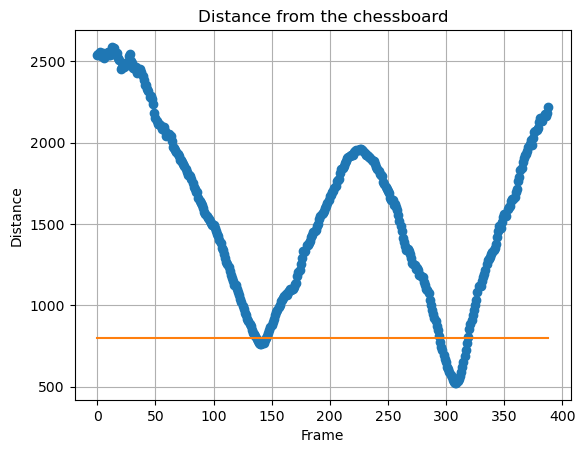

In [40]:
list_mean_disparity = []
disparity_map_list_SGBM = []

minDisparity=0                   # Minimum possible disparity value
numDisparities=128               # Range of disparity (maxDisparity - minDisparity)
block_size= 21                   # Size of the window used for matching (odd values only)
P1=0                             # Penalty for the first pixel disparity difference
P2=0                             # Penalty for the second pixel disparity difference
disp12MaxDiff=0                  # Maximum allowed difference in the left-right disparity check
preFilterCap=0                   # Maximum allowed difference in the left-right disparity check
uniquenessRatio=0                # Margin in percentage by which the best (minimum) computed cost function value should "win"
speckleWindowSize=0              # Maximum size of smooth disparity regions to consider them as a speckle
speckleRange=0                   # Maximum disparity variation within each connected component
mode = 0                         # Set it to StereoSGBM::MODE_HH to run the full-scale two-pass dynamic programming algorithm.

stereo = cv2.StereoSGBM_create(minDisparity,numDisparities,block_size,P1,P2,disp12MaxDiff,preFilterCap,uniquenessRatio,speckleWindowSize,speckleRange,mode)

print("Mean disparity (d_mean) for each frame:")
for framenumber in range(number_of_frames):
    disparity = stereo.compute(list_L_cropped[framenumber],list_R_cropped[framenumber])
    positive_disparities = disparity[disparity >= 0]
    disparity_px=(positive_disparities/16)
    
    mean_disparity = np.mean(disparity_px)

    list_mean_disparity.append(mean_disparity)
    d_mean = np.mean(disparity_px)
    mean_disparity = round(d_mean, 2)

    print(f"{framenumber}: {mean_disparity}")
    
    disparity_map_list_SGBM.append(disparity)

# distance calculation

list_z_SGBM = []
for framenumber in range(number_of_frames):
        z = (b * f)/list_mean_disparity[framenumber]
        list_z_SGBM.append(z)

# Plotting
f_values = list(range(number_of_frames))
plt.plot(f_values, list_z_SGBM, marker='o', linestyle='-')
line = 800*np.ones((len(f_values)))
plt.plot(f_values, line)
plt.title('Distance from the chessboard')
plt.xlabel('Frame')
plt.ylabel('Distance')
plt.grid(True)
plt.show()

# Width and Height estimation of the chessboard pattern <a id="width-and-height-estimation-of-the-chessboard-pattern"></a>

This code segment aims to find and refine the corners of a chessboard pattern in a series of grayscale images using OpenCV. The code iterates through each grayscale images (one left and one right) in the numpy array np_L_gray and np_R_gray.

The 'cv2.findChessboardCorners' function attempts to find the corners of the chessboard pattern in the current grayscale image (frame). It returns a boolean value (found) indicating whether the pattern is found and an array (corners) containing the coordinates of the corners if found. the 'list_foundL.append(found)' is a boolean value indicating whether the pattern is found (found) is added to the list_foundL list. 

If the pattern is found (found == True):
    The 'cv2.cornerSubPix' function refines the corner positions to subpixel accuracy using an iterative approach until the criteria specified by term are satisfied. The refined corner positions are updated in place in the corners array.
    The progress is printed to track the processing of frames.
    The refined corner positions (corners) are added to the 'list_cornersL' list.

If the pattern is not found (found == False):
    A message indicating that the pattern is not found is printed.
    None is appended to the list_cornersL list to indicate that no corners were found in the current frame.

Overall, this code segment performs corner detection and refinement for a chessboard pattern in a series of grayscale images, storing the results for further processing or analysis.

In [41]:
# Find chessboard corners in each frame for left camera

pattern_size = (6, 8) # number of inner corner, (columns, rows) for OpenCV

# These lists are initialized to store information about whether the chessboard pattern is found (list_foundL)
# and the coordinates of the corners (list_cornersL) for each frame in the series of grayscale images.
list_foundL = []
list_cornersL = []

progress = 0
for frame in np_L_gray:
    found, corners = cv2.findChessboardCorners(frame, pattern_size)
    list_foundL.append(found)
    
    progress+=1
    if found:
        #Refining corner position to subpixel iteratively until criteria max_count=30 or criteria_eps_error=1 is sutisfied
        term = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_COUNT, 30, 1) #Defines convergence criteria for corner refinement in OpenCV
        #Image Corners 
        cv2.cornerSubPix(frame, corners, (5, 5), (-1, -1), term)
        print(progress, end=', ')
        list_cornersL.append(corners)
    else:
        print("not found", progress, end=', ')
        #list_foundL.append(None)
        list_cornersL.append(None)

print("job completed")

not found 1, 2, not found 3, 4, 5, not found 6, 7, 8, 9, not found 10, not found 11, not found 12, not found 13, 14, not found 15, 16, not found 17, not found 18, 19, not found 20, 21, not found 22, not found 23, 24, not found 25, not found 26, not found 27, not found 28, 29, not found 30, 31, not found 32, not found 33, not found 34, not found 35, not found 36, 37, 38, 39, not found 40, not found 41, not found 42, not found 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168

In [42]:
# Find chessboard corners in each frame for right camera

list_foundR = []
list_cornersR = []

progress = 0
for frame in np_R_gray:
    found, corners = cv2.findChessboardCorners(frame, pattern_size)
    list_foundR.append(found)
    
    progress+=1
    if found:
        #Refining corner position to subpixel iteratively until criteria max_count=30 or criteria_eps_error=1 is sutisfied
        term = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_COUNT, 30, 1)
        #Image Corners 
        cv2.cornerSubPix(frame, corners, (5, 5), (-1, -1), term)
        print(progress, end=', ')
        list_cornersR.append(corners)
    else:
        print("not found", progress, end=', ')
        list_cornersR.append(None)

print("job completed")

1, 2, 3, 4, 5, 6, 7, not found 8, 9, 10, not found 11, 12, not found 13, 14, not found 15, 16, not found 17, not found 18, not found 19, not found 20, not found 21, not found 22, not found 23, 24, not found 25, not found 26, not found 27, not found 28, 29, not found 30, not found 31, not found 32, not found 33, not found 34, not found 35, not found 36, 37, 38, not found 39, 40, 41, not found 42, not found 43, 44, 45, 46, 47, 48, 49, 50, 51, not found 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, not found 70, not found 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166

# Dimension of the chessboard <a id="dimension-of-the-chessboard"></a>

First of all we used the OpenCV functions cvFindChessboardCorners and cvDrawChessboardCorners may be deployed to, respectively, find and display the pixel coordinates of the internal corners of the chessboard. After we assuming the chessboard pattern to be parallel to the image plane of the stereo sensor, the real dimensions of the pattern can be obtained from their pixel dimensions (w,h) by the following formulas: 

$$ W(mm) = \frac {z(mm)\cdot w(pixel)}{f(pixel)}$$
{8}

$$ H(mm) = \frac {z(mm)\cdot h(pixel)}{f(pixel)}$$
{9}

    W       -length of the chessboard
    H       -hight of the chessboard
    f       -focal length
    z       -distance of the obstacle wrt to the moving vehicle

We compare the estimated real dimensions to the known ones (125 mm x 178 mm) to verify that accuracy becomes higher as the vehicle gets closer to the pattern.

### Computation of the dimension of the chessboard

In [43]:
W_mm_list = []
H_mm_list = []
W_mm_diff = []
H_mm_diff = []
w_px_list = []
h_px_list = []

for frame in range(number_of_frames):
    if list_foundL[frame] and list_foundR[frame]:
        w_px = 0
        h_px = 0
        for w_line in range(8):
            w_px_R = list_cornersR[frame][6*w_line+5][0][0]-list_cornersR[frame][6*w_line+0][0][0]
            w_px_L = list_cornersL[frame][6*w_line+5][0][0]-list_cornersL[frame][6*w_line+0][0][0]
            w_px = w_px+w_px_L
        for h_line in range(6):
            h_px_R = list_cornersR[frame][42+h_line][0][1]-list_cornersR[frame][0+h_line][0][1]
            h_px_L = list_cornersL[frame][42+h_line][0][1]-list_cornersL[frame][0+h_line][0][1]
            h_px = h_px+h_px_L
       
        w_px = w_px/8
        h_px = h_px/6
        W_mm = w_px*list_z_SGBM[frame]/f    
        H_mm = h_px*list_z_SGBM[frame]/f  
        w_px_list.append(w_px)
        h_px_list.append(h_px)
        W_mm_diff.append(W_mm-125)
        H_mm_diff.append(H_mm-178)
    else:
        w_px_list.append(None)
        h_px_list.append(None)
        W_mm_diff.append(None)
        H_mm_diff.append(None)

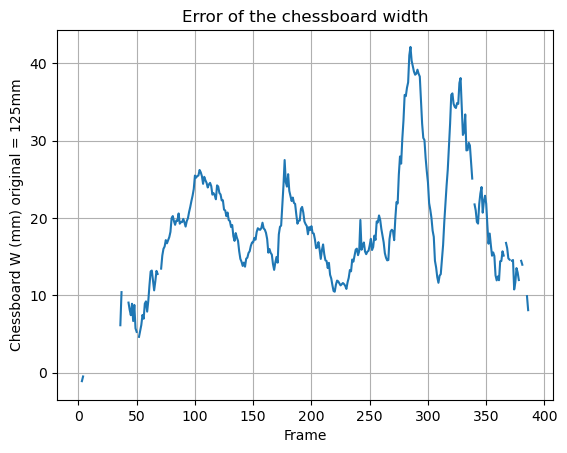

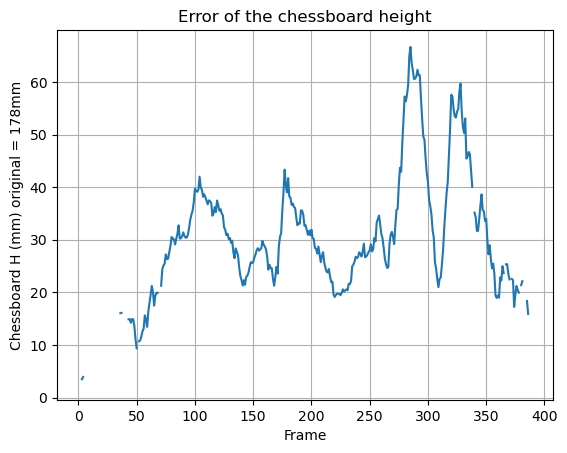

In [44]:
# Plotting
f_values = list(range(number_of_frames))
plt.plot(f_values, W_mm_diff)
plt.title('Error of the chessboard width')
plt.xlabel('Frame')
plt.ylabel('Chessboard W (mm) original = 125mm')
plt.grid(True)
plt.show()

# Plotting
f_values = list(range(number_of_frames))
plt.plot(f_values, H_mm_diff)
plt.title('Error of the chessboard height')
plt.xlabel('Frame')
plt.ylabel('Chessboard H (mm) original = 178mm')
plt.grid(True)
plt.show()

# Improvements <a id="improvements-1"></a>

## 1. Distance with customs function and with the offset <a id="1-distance-with-customs-function-and-with-the-offset"></a>

#### StereoSGBM 

# ????? #


# 2. Splitting the image into vertical strips <a id="2-splitting-the-image-into-vertical-strips"></a>

This code segment performs _stereo depth estimation_ using the StereoSGBM algorithm from OpenCV. It divides the images into strips, calculates the mean disparity for each strip, converts disparity to depth in millimeters, and calculates the average depth and average angle of inclination for each frame. Finally, it accumulates these values in lists for further analysis and processing.

In [51]:
no_of_strips = 5
strip_width = int(np_L_gray.shape[2]/no_of_strips)

list_mean_disparity = []
list_z_mm = []
list_tau = []

numDisparities=112
blockSize=11

stereo = cv2.StereoSGBM_create(0, numDisparities, blockSize)

for framenumber in range(number_of_frames): 
    list_frame_disparity = []
    list_frame_z = []
    list_frame_tau = []
    
    for strip in range(no_of_strips):
        L_img = np_L_gray[framenumber,:,strip*strip_width:(strip+1)*strip_width]
        R_img = np_R_gray[framenumber,:,strip*strip_width:(strip+1)*strip_width]

        disparity = stereo.compute(L_img,R_img)
        
        positive_disparities = disparity[disparity > 0]
        disparity_px=(positive_disparities/16) 
        mean_disparity = np.mean(disparity_px)
        list_frame_disparity = list_frame_disparity + [mean_disparity]
        z_mm = (f*b)/mean_disparity
        list_frame_z = list_frame_z + [z_mm]

        if not(strip==0):
            tau = atan((list_frame_z[strip-1] - z_mm)*f/(strip_width*z_mm))*180/pi
            list_frame_tau = list_frame_tau + [tau]
            
    list_mean_disparity = list_mean_disparity + [list_frame_disparity]
    avg_z = sum(list_frame_z)/no_of_strips
    avg_tau = sum(list_frame_tau)/(no_of_strips-1)
    list_z_mm = list_z_mm + [avg_z]
    list_tau = list_tau + [avg_tau]

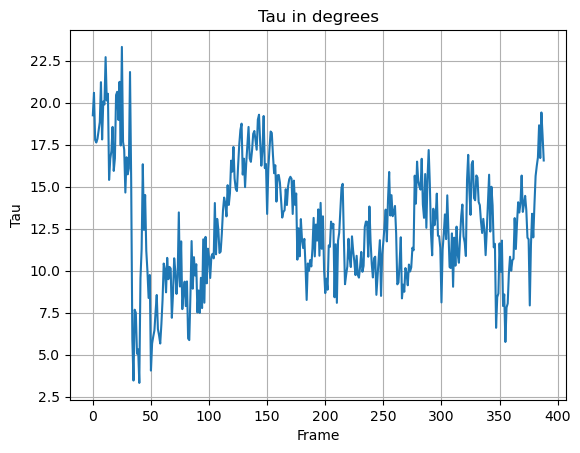

In [52]:
# Plotting
f_values = list(range(number_of_frames))
plt.plot(f_values, list_tau)
plt.title('Tau in degrees')
plt.xlabel('Frame')
plt.ylabel('Tau')
plt.grid(True)
plt.show()

This code _calculates the width and height in millimeters of an object_ detected in each frame of a video. It measures the width and height in pixels of the detected object, converts these pixel measurements to millimeters using depth information, and then calculates the differences between these measurements and predefined reference values. If the object is not detected in a frame, it assigns None values to the width, height, and their differences.

In [53]:
W_mm_list = []
H_mm_list = []
W_mm_diff = []
H_mm_diff = []
w_px_list = []
h_px_list = []
for frame in range(number_of_frames):
    if list_foundL[frame] and list_foundR[frame]:
        w_px = 0
        h_px = 0
        for w_line in range(8):
            w_px_R = list_cornersR[frame][6*w_line+5][0][0]-list_cornersR[frame][6*w_line+0][0][0]
            w_px_L = list_cornersL[frame][6*w_line+5][0][0]-list_cornersL[frame][6*w_line+0][0][0]
            w_px = w_px+w_px_L+w_px_R
        for h_line in range(6):
            h_px_R = list_cornersR[frame][42+h_line][0][1]-list_cornersR[frame][0+h_line][0][1]
            h_px_L = list_cornersL[frame][42+h_line][0][1]-list_cornersL[frame][0+h_line][0][1]
            h_px = h_px+h_px_L+h_px_R
       
        w_px = w_px/16
        h_px = h_px/12
        W_mm = w_px*list_z_mm[frame]/(f*cos(pi*list_tau[frame]/180))
        H_mm = h_px*list_z_mm[frame]/(f*cos(pi*list_tau[frame]/180))
        W_mm_list.append(W_mm)
        H_mm_list.append(H_mm) 
        w_px_list.append(w_px)
        h_px_list.append(h_px) 
        W_mm_diff.append(W_mm-125)
        H_mm_diff.append(H_mm-178)
    else:
        W_mm_list.append(None)
        H_mm_list.append(None)
        w_px_list.append(None)
        h_px_list.append(None)
        W_mm_diff.append(None)
        H_mm_diff.append(None)
    

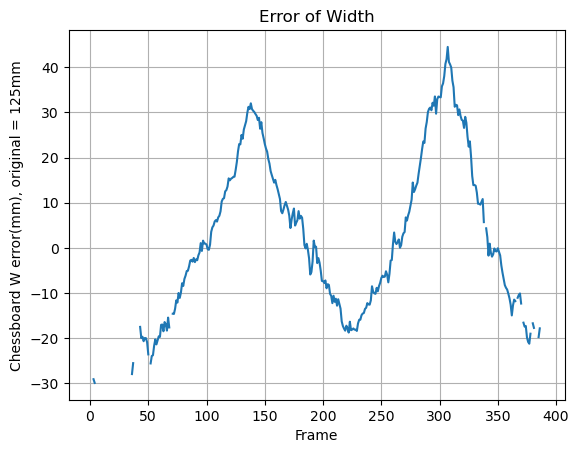

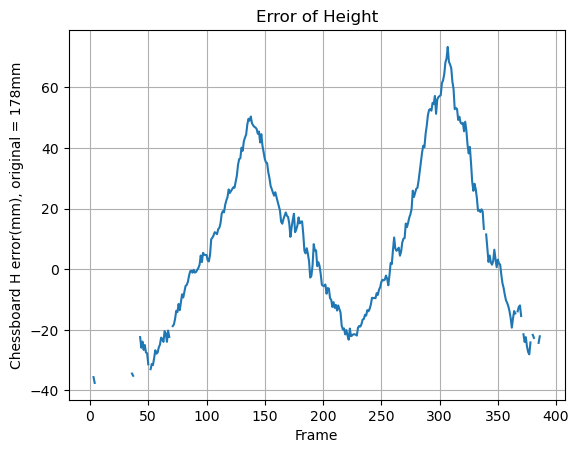

In [54]:
# Plotting
f_values = list(range(number_of_frames))
plt.plot(f_values, W_mm_diff)
plt.title('Error of Width')
plt.xlabel('Frame')
plt.ylabel('Chessboard W error(mm), original = 125mm')
plt.grid(True)
plt.show()

# Plotting
f_values = list(range(number_of_frames))
plt.plot(f_values, H_mm_diff)
plt.title('Error of Height')
plt.xlabel('Frame')
plt.ylabel('Chessboard H error(mm), original = 178mm')
plt.grid(True)
plt.show()

## 3. Compute disparity using the salient points <a id="3-compute-disparity-using-the-salient-points"></a>

#### TODO explain

In [55]:
# store couple of x coordinates of corners in left and right images only if corners are found in both images

list_Lxi = []
list_Rxi = []

for frame in range(number_of_frames):
    if list_foundL[frame] and list_foundR[frame]:
        Lxi_frame = [elem[0][0] for elem in list_cornersL[frame]]
        Rxi_frame = [elem[0][0] for elem in list_cornersR[frame]]
        list_Lxi.append(Lxi_frame)
        list_Rxi.append(Rxi_frame)
    else:
        list_Lxi.append(None)
        list_Rxi.append(None)
        
print(len(list_Rxi),'frames in which corners are found in both images')

# Calculate disparity as a difference of the position on x axis for each frame

list_d = []
for frame in range(number_of_frames):
    diffs = []
    if list_foundL[frame] and list_foundR[frame]:
        for l, r in zip(list_Lxi[frame], list_Rxi[frame]):
            diff = l - r
            diffs.append(diff)
        d = sum(diffs)/len(diffs)
        list_d.append(d)
    else:
        list_d.append(None)

# Calculate distance for each frame with the previous formula {7}

list_z_chessboard = []
for frame in range(number_of_frames):
    if list_foundL[frame] and list_foundR[frame]:
        z = (b * f)/list_d[frame]
        list_z_chessboard.append(z)
    else:
        list_z_chessboard.append(None)

389 frames in which corners are found in both images


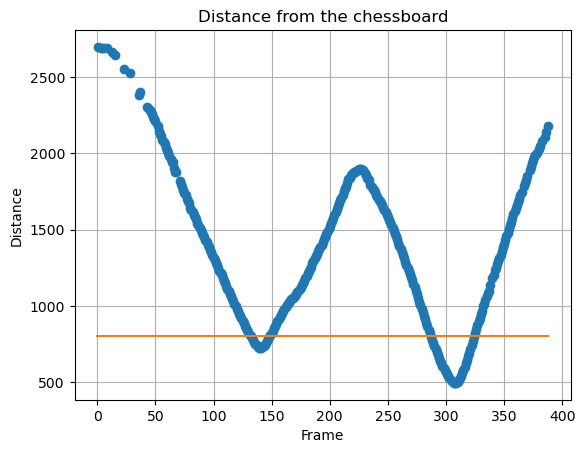

In [56]:
# Plotting
f_values = list(range(number_of_frames))
plt.plot(f_values, list_z_chessboard, marker='o', linestyle='-')
line = 800*np.ones((len(f_values)))
plt.plot(f_values, line)
plt.title('Distance from the chessboard')
plt.xlabel('Frame')
plt.ylabel('Distance')
plt.grid(True)
plt.show()

 # Explan the intrest point

0 : 19.714285714285715
1 : 19.8
2 : 19.56
3 : 19.875
4 : 19.666666666666668
5 : 19.416666666666668
6 : 19.379310344827587
7 : 19.571428571428573
8 : 19.692307692307693
9 : 19.608695652173914
10 : 19.85
11 : 19.954545454545453
12 : 19.65
13 : 19.714285714285715
14 : 19.56
15 : 20.115384615384617
16 : 19.523809523809526
17 : 20.142857142857142
18 : 20.25
19 : 20.307692307692307
20 : 19.894736842105264
21 : 20.11111111111111
22 : 20.14814814814815
23 : 20.681818181818183
24 : 20.58823529411765
25 : 20.625
26 : 20.75
27 : 20.458333333333332
28 : 19.842105263157894
29 : 20.57894736842105
30 : 20.291666666666668
31 : 20.666666666666668
32 : 20.535714285714285
33 : 20.678571428571427
34 : 20.47826086956522
35 : 20.333333333333332
36 : 21.0
37 : 20.4
38 : 20.75862068965517
39 : 20.58823529411765
40 : 21.05
41 : 21.61904761904762
42 : 21.210526315789473
43 : 21.636363636363637
44 : 21.714285714285715
45 : 21.714285714285715
46 : 22.26923076923077
47 : 22.23076923076923
48 : 22.529411764705884
4

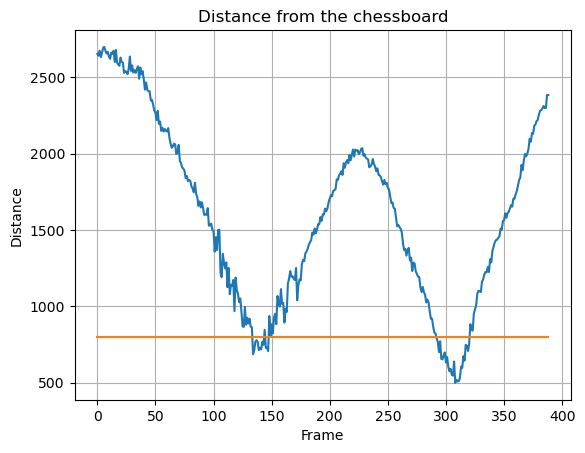

In [61]:
list_mean_disparity = []
list_z_PT = []
frame_height = list_L_cropped[0].shape[1]
frame_width = list_L_cropped[0].shape[0]

block_size = 21
cost_fn = ssd_fn
crop_border = block_size//2
number_lines = 5
no_of_corners = 200
d_max = 128
hidden_area = 20 
cost_threshold = 10000

def cost_given_2_pixels(L_img, R_img, L_pixel_x, R_pixel_x, pixel_Ly, pixel_Ry, cost_fn,crop_border):
    L_window = L_img[pixel_Ly-crop_border:pixel_Ly+crop_border+1, L_pixel_x-crop_border:L_pixel_x+crop_border+1]
    R_window = R_img[pixel_Ry-crop_border:pixel_Ry+crop_border+1, R_pixel_x-crop_border:R_pixel_x+crop_border+1]
    return cost_fn(L_window, R_window)
 
for framenumber in range(number_of_frames):
    corners_L = cv2.goodFeaturesToTrack(list_L_cropped[framenumber],no_of_corners,0.01,10)
    corners_L = np.int0(corners_L)
    corners_R = cv2.goodFeaturesToTrack(list_R_cropped[framenumber],no_of_corners,0.01,10)
    corners_R = np.int0(corners_R)
    
    features_in_line_Left = [[] for _ in range(frame_height)]
    features_in_line_Right = [[] for _ in range(frame_height)]
    list_disparity = []
    # Append corners to the corresponding lists
    for corner in corners_L:
        y = corner[0][1]
        features_in_line_Left[y].append(corner)
    for corner in corners_R:
        y = corner[0][1]
        features_in_line_Right[y].append(corner)
    
    for y in range(crop_border+1+number_lines, frame_height-crop_border-1-number_lines):
        for corner_L in features_in_line_Left[y]:
            if corner_L[0][0] < hidden_area:
                continue
            min_cost = np.inf
            disparity = -1
            for line in range(y-number_lines, y+number_lines):
                for corner_R in features_in_line_Right[line]:
                    L_x = corner_L[0][0]
                    R_x = corner_R[0][0]
                    if L_x < crop_border or R_x < crop_border or L_x > frame_width-crop_border-1 or R_x > frame_width-crop_border-1:
                        continue
                    if (L_x > R_x) and (L_x-R_x < d_max):
                        #print(y, line, L_x, R_x)
                        cost = cost_given_2_pixels(list_L_cropped[framenumber], list_R_cropped[framenumber], L_x, R_x, y, line, cost_fn, crop_border)
                        if min_cost > cost and cost < cost_threshold:
                            min_cost = cost
                            disparity = L_x - R_x
            if disparity > 0:
                list_disparity.append(disparity)
                     
    mean_disparity = np.mean(list_disparity)
    list_mean_disparity.append(mean_disparity)
    print(framenumber, ":", mean_disparity)
    
    z = (b * f)/list_mean_disparity[framenumber]
    list_z_PT.append(z)
    
# Plotting
f_values = list(range(number_of_frames))
plt.plot(f_values, list_z_PT, linestyle='-')
line = 800*np.ones((len(f_values)))
plt.plot(f_values, line)
plt.title('Distance from the chessboard')
plt.xlabel('Frame')
plt.ylabel('Distance')
plt.grid(True)
plt.show()

### Add a threshold value
This function is used to apply a thresholding operation to the cost array based on the 'disparity' values and the chosen 'cost_fn'. _It replaces certain disparity values with '-1' if their corresponding 'cost' values exceed a certain threshold, and replaces others with 'np.nan'_.

The threshold is therefore used to obtain a more accurate disparity map, and for each 'cost_fn', dissimilarity values are discarded, highlighting them in black, and keeping only the similar ones.

In [67]:
def cost_thresholding(disparity, cost, cost_fn):
    cost_region = cost[disparity > 0] 
    if cost_fn == sad_fn or cost_fn == ssd_fn:
        #threshold = np.mean(cost_region) + 2*np.std(cost_region)
        threshold = np.median(cost_region)
        mask = (cost < threshold) | (cost == -2)
    else:
        #threshold = np.mean(cost_region) #- 2*np.std(cost_region)
        threshold = np.median(cost_region)
        mask = (cost > threshold) | (cost == -2)
        
    print("threshold:", round(threshold, 2))
        
    # set disparity to -1 where cost is above threshold
    return np.where(mask, disparity, np.nan)

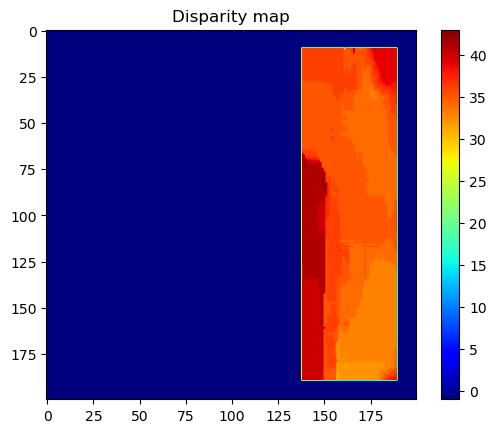

threshold: -0.04


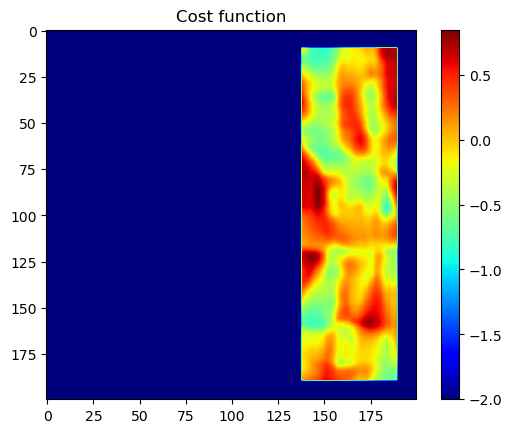

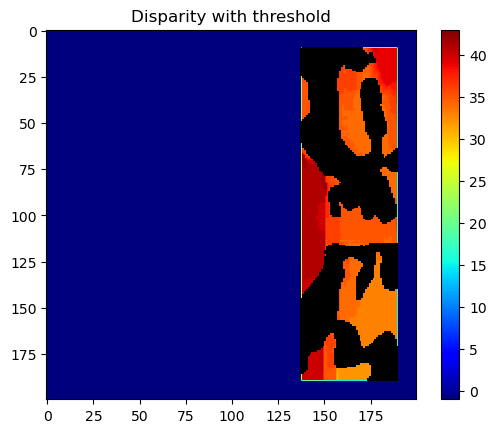

mean disparity 35.61527777777778
mean disparity afeter appling threshold 36.02094017094017


In [70]:
framenumber = 100

min_disparity = 0
d_max = 128 #Max value of disparities 
block_size = 21

#Choose the function
cost_fn = zncc_fn # sad_fn, ssd_fn, ncc_fn, zncc_fn

#Choose the approach
#disparity = compute_disparity_map(np_L_cropped, np_R_cropped, d_max, block_size, cost_fn)
disparity, cost = compute_disparity_map_parallel(list_L_cropped[framenumber],list_R_cropped[framenumber], d_max, block_size, min_disparity, cost_fn)

plt.imshow(disparity, cmap = 'jet')
plt.title (f'Disparity map')
plt.colorbar()
plt.show()

filtered_disparity = cost_thresholding(disparity, cost, cost_fn)

plt.imshow(cost, cmap = 'jet')
plt.title (f'Cost function')
plt.colorbar()
plt.show()

# Create a colormap that shows 'bad' values (i.e., NaNs) in black
cmap = plt.cm.jet
cmap.set_bad(color='black')

plt.imshow(filtered_disparity, cmap = cmap)
plt.title(f'Disparity with threshold')
plt.colorbar()
plt.show()

positive_disparities = disparity[disparity > 0]
mean_disparity = np.mean(positive_disparities)
print("mean disparity", mean_disparity)

positive_disparities_filtered = filtered_disparity[filtered_disparity > 0]
mean_disparity = np.mean(positive_disparities_filtered)
print("mean disparity afeter appling threshold", mean_disparity)

# Distance estimation by using custom disparity function and improvments

This code calculate the mean disparity for each frame in a stereo pair of images using different cost functions like Sum of Squared Differences (SSD), Sum of Absolute Differences (SAD), Normalized Cross-Correlation (NCC), and Zero-mean Normalized Cross-Correlation (ZNCC).

In the first part of the code is used the function 'calculate_disparity', initially is necessary to initialize lists to store mean disparity, disparity maps, and costs. Within the loop for each frame the following operation are runs. Computes the initial offset and applies smoothing to it. Adjusts 'min_disparity' and 'd_max' based on the smoothed offset. Computes disparity map and cost using a parallelized function 'compute_disparity_map_parallel()'. Computes the mean disparity and stores it. Appends disparity map and cost to respective lists. At the end the function returns lists of mean disparity, disparity maps, and costs. 

In the second part of the code sets parameters like 'disparity_range' and 'window_size'.
Runs the 'calculate_disparity()' function multiple times with different block sizes and cost functions ('ssd_fn', 'sad_fn', 'ncc_fn', 'zncc_fn').
Computes depth values 'z' using the formula '(baseline * focal_length) / mean_disparity' for each case.


In [ ]:
def calculate_disparity(number_of_frames, list_L_cropped, list_R_cropped, d_max, block_size, min_disparity, cost_fn, disparity_range):
    
    cost_fn_mapping = {
    ssd_fn: "SSD",
    sad_fn: "SAD",
    ncc_fn: "NCC",
    zncc_fn: "ZNCC"
    }
    
    list_mean_disparity = []
    disparity_map_list = []
    cost_list = []
    d_mean = disparity_range/2
    
    for framenumber in range(number_of_frames):
        
        offset = int(d_mean - disparity_range/2)
        if offset < 0:
            offset = 0
        if offset > disparity_range:
            offset = disparity_range
        
        min_disparity = int(offset)
        d_max = disparity_range+int(offset)
    
        disparity, cost = compute_disparity_map_parallel(list_L_cropped[framenumber],list_R_cropped[framenumber], d_max, block_size, min_disparity, cost_fn)
        
        filtered_disparity = cost_thresholding(disparity, cost, cost_fn)
        
        positive_disparities_filtered = filtered_disparity[filtered_disparity > 0]   
            
        d_mean = np.mean(positive_disparities_filtered)
        list_mean_disparity.append(d_mean)
        
        cost_list.append(cost)
        
        mean_disparity = round(d_mean, 2)
        
        print("#######",cost_fn_mapping.get(cost_fn, "Unknown cost function"),"#######")
        print("range: ",min_disparity,":",d_max)
        print(f"frame {framenumber}: d_mean is {mean_disparity}")
        
        disparity_map_list.append(filtered_disparity)
    return list_mean_disparity, disparity_map_list, cost_list



disparity_range=64
block_size = 21
I_want_to_run_this = False #True


if I_want_to_run_this:
    list_mean_disparity_SSD, disparity_map_list_custom_SSD, cost_SSD = calculate_disparity(number_of_frames, list_L_cropped, list_R_cropped, d_max, block_size, min_disparity, ssd_fn, disparity_range)

    list_z_SSD = []
    for framenumber in range(number_of_frames):
            z = (b * f)/list_mean_disparity_SSD[framenumber]
            list_z_SSD.append(z)
    
    list_mean_disparity_SAD, disparity_map_list_custom_SAD, cost_SAD = calculate_disparity(number_of_frames, list_L_cropped, list_R_cropped, d_max, block_size, min_disparity, sad_fn, disparity_range)

    
    list_z_SAD = []
    for framenumber in range(number_of_frames):
            z = (b * f)/list_mean_disparity_SAD[framenumber]
            list_z_SAD.append(z)
    
    list_mean_disparity_NCC, disparity_map_list_custom_NCC, cost_NCC = calculate_disparity(number_of_frames, list_L_cropped, list_R_cropped, d_max, block_size, min_disparity, ncc_fn, disparity_range)

    list_z_NCC = []
    for framenumber in range(number_of_frames):
            z = (b * f)/list_mean_disparity_NCC[framenumber]
            list_z_NCC.append(z)
    
    list_mean_disparity_ZNCC, disparity_map_list_custom_ZNCC, cost_ZNCC = calculate_disparity(number_of_frames, list_L_cropped, list_R_cropped, d_max, block_size, min_disparity, zncc_fn, disparity_range)

    list_z_ZNCC = []
    for framenumber in range(number_of_frames):
            z = (b * f)/list_mean_disparity_ZNCC[framenumber]
            list_z_ZNCC.append(z)
        

This code essentially checks for the existence of a directory, deletes its contents if it exists, or creates the directory if it doesn't. Then it stores data into a dictionary and saves it in chunks, each of size 50 MB, using pickle serialization and gzip compression.

Initially checks if a directory named 'data' already exists, if it exists removes each file from the directory using 'os.remove()' else creates a new directory named 'data' using 'os.makedirs()'. 
The code block called 'data' defines a dictionary named data. It stores various data lists and arrays such as list_z_SSD,'list_mean_disparity_SAD', etc., presumably generated earlier in the code.

After that divide data into chunks and save. Define the 'chunk_size' is the size of each data chunk as 50 MB. Initializes the chunk number and the current chunk size counter. Opens a gzip-compressed file with 'gzip.open()' to write data chunks.
Iterates through the items in the data dictionary, for each of them: serializes the key-value pair using 'pickle.dumps()'; Checks if adding the current item exceeds the chunk size limit; Writes the serialized data to the current chunk file; Updates the current chunk size counter. 

At the end closes the last chunk file.

In [62]:
if I_want_to_run_this:
    if os.path.exists('data'):
        
        file_list = os.listdir('data')
        
        for file_name in file_list:
            file_path = os.path.join('data', file_name)
            os.remove(file_path)
    
    else:
        os.makedirs ('data')
        
    # todo delete data before storing it

    # Store data
    data = {
        "list_z_SSD": list_z_SSD,
        "list_z_SAD": list_z_SAD,
        "list_z_NCC": list_z_NCC,
        "list_z_ZNCC": list_z_ZNCC,
        "list_mean_disparity_SSD": list_mean_disparity_SSD,
        "list_mean_disparity_SAD": list_mean_disparity_SAD,
        "list_mean_disparity_NCC": list_mean_disparity_NCC,
        "list_mean_disparity_ZNCC": list_mean_disparity_ZNCC,
        "cost_SSD": cost_SSD,
        "cost_SAD": cost_SAD,
        "cost_NCC": cost_NCC,
        "cost_ZNCC": cost_ZNCC,
        "disparity_map_list_custom_SSD": disparity_map_list_custom_SSD,
        "disparity_map_list_custom_SAD": disparity_map_list_custom_SAD,
        "disparity_map_list_custom_NCC": disparity_map_list_custom_NCC,
        "disparity_map_list_custom_ZNCC": disparity_map_list_custom_ZNCC
    }


   #divide file when they are equal to 50MB and save it

    chunk_size = 50 * 1024 * 1024  # 50 MB
    chunk_number = 1
    current_chunk_size = 0
    chunk_file = gzip.open(f'data/data_chunk_{chunk_number}.pickle.gz', 'wb')

    for key, value in data.items():
        pickled_item = pickle.dumps((key, value))
        if current_chunk_size + len(pickled_item) > chunk_size:
            chunk_file.close()
            chunk_number += 1
            chunk_file = gzip.open(f'data/data_chunk_{chunk_number}.pickle.gz', 'wb')
            current_chunk_size = 0
        chunk_file.write(pickled_item)
        current_chunk_size += len(pickled_item)

    chunk_file.close()
        

This part is about restored previously divided data files, extracting specific data from them and assigning it to individual variables for further use.

With the function 'combine_chunks()' we recombines split files into a single directionary. Iterates over chunk files, appending data to the dictionary until no more chunks are found and at the end returns the combined dictionary. Calls 'combine_chunks()' function with the file prefix 'data/data_chunk'.
Extracts specific data from the combined dictionary, assigning each to its respective variable

In [63]:
#restore the divided files 

# Combine split files into a single dictionary
def combine_chunks(file_prefix):
    combined_data = {}
    chunk_number = 1
    while True:
        chunk_filename = f'{file_prefix}_{chunk_number}.pickle.gz'
        if not os.path.exists(chunk_filename):
            break
        with gzip.open(chunk_filename, 'rb') as fn:
            while True:
                try:
                    key, value = pickle.load(fn)
                    combined_data[key] = value
                except EOFError:
                    break
        chunk_number += 1
    return combined_data

data = combine_chunks('data/data_chunk')

list_z_SSD = data["list_z_SSD"]
list_z_SAD = data["list_z_SAD"]
list_z_NCC = data["list_z_NCC"]
list_z_ZNCC = data["list_z_ZNCC"]
list_mean_disparity_SSD = data["list_mean_disparity_SSD"]
list_mean_disparity_SAD = data["list_mean_disparity_SAD"]
list_mean_disparity_NCC = data["list_mean_disparity_NCC"]
list_mean_disparity_ZNCC = data["list_mean_disparity_ZNCC"]
cost_SSD = data["cost_SSD"]
cost_SAD = data["cost_SAD"]
cost_NCC = data["cost_NCC"]
cost_ZNCC = data["cost_ZNCC"]
disparity_map_list_custom_SSD= data["disparity_map_list_custom_SSD"]
disparity_map_list_custom_SAD= data["disparity_map_list_custom_SAD"]
disparity_map_list_custom_NCC= data["disparity_map_list_custom_NCC"]
disparity_map_list_custom_ZNCC= data["disparity_map_list_custom_ZNCC"]




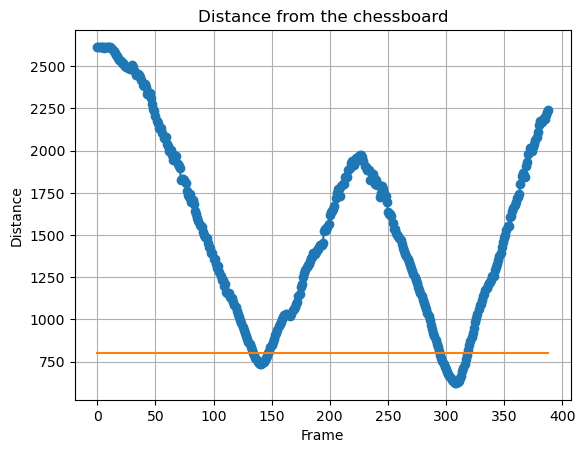

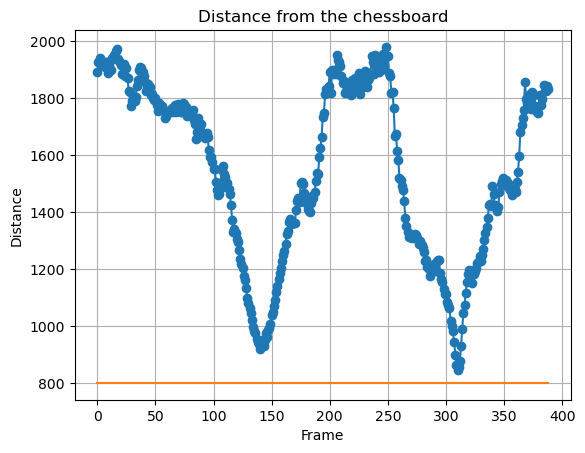

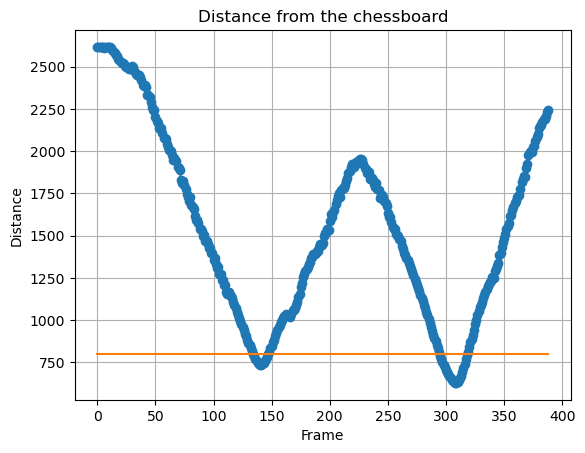

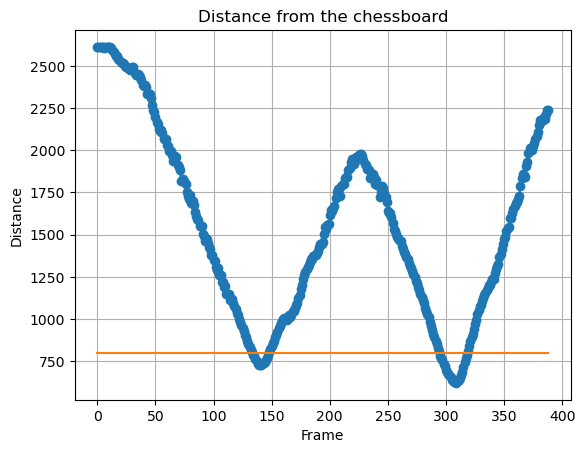

In [64]:
# Plotting
f_values = list(range(number_of_frames))
plt.plot(f_values, list_z_SSD, marker='o', linestyle='-')
line = 800*np.ones((len(f_values)))
plt.plot(f_values, line)
plt.title('Distance from the chessboard')
plt.xlabel('Frame')
plt.ylabel('Distance')
plt.grid(True)
plt.show()

# Plotting
f_values = list(range(number_of_frames))
plt.plot(f_values, list_z_SAD, marker='o', linestyle='-')
line = 800*np.ones((len(f_values)))
plt.plot(f_values, line)
plt.title('Distance from the chessboard')
plt.xlabel('Frame')
plt.ylabel('Distance')
plt.grid(True)
plt.show()

# Plotting
f_values = list(range(number_of_frames))
plt.plot(f_values, list_z_NCC, marker='o', linestyle='-')
line = 800*np.ones((len(f_values)))
plt.plot(f_values, line)
plt.title('Distance from the chessboard')
plt.xlabel('Frame')
plt.ylabel('Distance')
plt.grid(True)
plt.show()

# Plotting
f_values = list(range(number_of_frames))
plt.plot(f_values, list_z_ZNCC, marker='o', linestyle='-')
line = 800*np.ones((len(f_values)))
plt.plot(f_values, line)
plt.title('Distance from the chessboard')
plt.xlabel('Frame')
plt.ylabel('Distance')
plt.grid(True)
plt.show()



# Results <a id="results"></a>

It's important to correctly set parameters such as the block_size (used for computing all disparities), which represents the pixel area analyzed in an image; the minDisparities and numDisparities, which respectively set the minimum and maximum allowed disparity values for the stereoBM and stereoSGBM functions. Additionally, for customized functions to calculate disparity, defining the disparity range along with its corresponding offset is crucial to obtain the min and max disparity values.

Each function used to calculate disparity, distance, and chessboard size yielded fairly reliable results. Some required more computational time than others because they utilized more resources for calculations. However, we can say that for disparity and distance from the chessboard to the wall, the customized functions that produced the most appreciable results were SSD and ZNCC, followed by NCC, and finally SAD. This is because the images we analyzed are in color. 

The improvements were highly beneficial for achieving greater accuracy in the computation. Each enhancement aimed to surpass the performance of the 'standard' implementation.

In the first improvement, an offset value was utilized to dynamically adapt the allowed range of disparity in the computation for each frame.

For the second improvement, each frame was divided into multiple strips (the more strips you have, the greater accuracy you can achieve). Disparity and the angle between the background and the frontal plane were calculated for each strip. This step is crucial for determining the error in millimeters of measurement of the chessboard dimensions throughout the entire video. It is evident that being too close to the detected object can compromise the camera's precision.

Finally, the third improvement focused on obtaining disparity using only the salient points of the image. The results yielded very accurate outcomes.

Follow an explicative video presentation of disparities and the distance z.

# Video Presentation <a id="video-presentation"></a>

Generate visualizations for each frame of a video. It plots the left and right camera images, their corresponding disparity map, and a graph showing distance information. It saves each visualization as an image file and prints the frame numbers. Additionally, the code sets up text annotations displaying the width and height of the detected object in millimeters, along with an alarm indication if the distance falls below a certain threshold. After saving the images, it deletes figure-related objects to manage memory efficiently and calls the garbage collector to free up any unused memory.

In [57]:
del list_cornersL, list_cornersR, list_foundL, list_foundR,  np_L_gray, np_R_gray, np_L, np_R, roboL_frames, roboR_frames

font = FontProperties()
font.set_family('monospace')

f_values = list(range(number_of_frames))
line = 800*np.ones((len(f_values)))

if not os.path.exists ('frames_CV2'):
    os.makedirs ('frames_CV2')

for framenumber in range(number_of_frames):
    fig, axs = plt.subplots(2,2,figsize=(10,10))
    axs[0, 0].set_title('Left Camera')
    axs[0, 0].imshow(list_L_cropped[framenumber], cmap='gray')
    axs[0, 0].axis('off')
    axs[0, 1].set_title('Right Camera')
    axs[0, 1].imshow(list_R_cropped[framenumber], cmap='gray')
    axs[0, 1].axis('off')
    axs[1, 0].set_title('Disparity Map with SGBM')
    axs[1, 0].imshow(disparity_map_list_SGBM[framenumber], cmap='jet')
    axs[1, 1].plot(f_values, list_z_SGBM)
    axs[1, 1].plot(f_values, line)
    axs[1, 1].set_title('Distance: '+str(round(list_z_SGBM[framenumber]/1000, 2))+' m')
    axs[1, 1].plot(framenumber, list_z_SGBM[framenumber], 'ro')
    
    # Add the text to the bottom of the figure
    W_mm_text = f"{W_mm_list[framenumber]:.2f} mm" if W_mm_list[framenumber] is not None else "Corners not found"
    H_mm_text = f"{H_mm_list[framenumber]:.2f} mm" if H_mm_list[framenumber] is not None else "Corners not found"
    plt.text(0.1, 0.05, f"Width: {W_mm_text}", ha='left', va='center', transform=plt.gcf().transFigure, fontproperties=font)
    plt.text(0.1, 0.02, f"Height: {H_mm_text}", ha='left', va='center', transform=plt.gcf().transFigure, fontproperties=font)
    
    if list_z_SGBM[framenumber]<800:
        axs[1, 1].text(100, 2200, 'ALARM!!', fontsize=20, color='red')
  
    plt.savefig('frames_CV2/frame'+str(framenumber)+'.png')
    plt.close(fig)
    
    print(framenumber, end=', ')

# Explicitly delete the figure and related objects
del axs
del fig
# Call the garbage collector
gc.collect() 

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 

351

Create a video file from a collection of image frames stored in a folder. It first specifies the folder containing the frames and retrieves the filenames of all the frames within it. Then, it reads the dimensions of the first frame to determine the width and height of the output video.
After defining the output video path and creating a VideoWriter object using the OpenCV library, it iterates through each frame filename, reads each frame, and writes it to the video. Finally, it releases the video writer, confirming the path where the video has been saved.

In [58]:
# Path to the frames folder
frames_folder = 'frames_CV2'

# Get the list of frame filenames
frame_filenames = os.listdir(frames_folder)

# Get the dimensions of the first frame
frame_path = os.path.join(frames_folder, frame_filenames[0])
frame = cv2.imread(frame_path)
height, width, _ = frame.shape

# Define the output video path
output_path = 'output_video_CV2.mp4'

# Create a VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video_writer = cv2.VideoWriter(output_path, fourcc, 15, (width, height))

# Write each frame to the video
for filename in frame_filenames:
    frame_path = os.path.join(frames_folder, filename)
    frame = cv2.imread(frame_path)
    video_writer.write(frame)
    
# Release the video writer
video_writer.release()

# Print the output path
print(f"Video saved to: {os.path.abspath(output_path)}")

Video saved to: /home/federico/Documents/scuola/UNIBO/Corsi/Image processing and visualization/RobotNavigation/output_video_CV2.mp4


Generate a series of plots for each frame of a video, displaying various visualizations related to cost maps, disparity maps, and distance measurements. It utilizes a three-column layout for each frame visualization. Following the principal steps:

1.  Preparation: It sets up necessary variables such as f_values (frame numbers) and line (a constant line indicating a specific value).
2.  Visualization Settings: It defines the colormap for 'bad' values (NaNs) as black and sets up the layout parameters for the plots.
3.  Creating Plots: It creates subplots for each frame, with each subplot representing different visualizations. The first column displays cost maps for different matching algorithms (SSD, SAD, NCC, ZNCC). The second column shows disparity maps corresponding to the cost maps. The third column presents distance measurements derived from each matching algorithm.
4.  Saving and Cleanup: It saves each frame visualization as an image file, closes the figure to release memory, and prints the frame numbers processed.
5.  Memory Management: It explicitly deletes figure-related objects and calls the garbage collector to manage memory usage efficiently.

In [59]:
# Plotting
f_values = list(range(number_of_frames))
line = 800*np.ones((len(f_values)))

cmap = plt.cm.jet # Create a colormap that shows 'bad' values (i.e., NaNs) in black
cmap.set_bad(color='black')

width_ratios = [1, 1, 1.5]

if not os.path.exists ('frames_CUSTOM'):
    os.makedirs ('frames_CUSTOM')

for framenumber in range(number_of_frames):
    fig, axs = plt.subplots(4,3, figsize=(10,10), gridspec_kw={'width_ratios': width_ratios})
    plt.subplots_adjust(left=0.2, right=0.9, top=0.9, bottom=0.1)
    
    fig.colorbar(axs[0, 0].imshow(cost_SSD[framenumber], cmap='jet'), ax=axs[0, 0]).ax.tick_params(labelsize=6)
    fig.colorbar(axs[1, 0].imshow(cost_SAD[framenumber], cmap='jet'), ax=axs[1, 0]).ax.tick_params(labelsize=6)
    fig.colorbar(axs[2, 0].imshow(cost_NCC[framenumber], cmap='jet'), ax=axs[2, 0]).ax.tick_params(labelsize=6)
    fig.colorbar(axs[3, 0].imshow(cost_ZNCC[framenumber], cmap='jet'), ax=axs[3, 0]).ax.tick_params(labelsize=6)
    
    fig.colorbar(axs[0, 1].imshow(disparity_map_list_custom_SSD[framenumber], cmap=cmap), ax=axs[0, 1]).ax.tick_params(labelsize=6)
    fig.colorbar(axs[1, 1].imshow(disparity_map_list_custom_SAD[framenumber], cmap=cmap), ax=axs[1, 1]).ax.tick_params(labelsize=6)
    fig.colorbar(axs[2, 1].imshow(disparity_map_list_custom_NCC[framenumber], cmap=cmap), ax=axs[2, 1]).ax.tick_params(labelsize=6)
    fig.colorbar(axs[3, 1].imshow(disparity_map_list_custom_ZNCC[framenumber], cmap=cmap), ax=axs[3, 1]).ax.tick_params(labelsize=6)
    
    # 1° COLUMN
    axs[0, 0].set_title('Cost Map')
    axs[0, 0].set_ylabel('SSD', fontsize='large', rotation=0, labelpad=25)
    axs[0, 0].imshow(cost_SSD[framenumber], cmap='jet')
    axs[0, 0].yaxis.set_tick_params(labelsize=6)
    axs[0, 0].xaxis.set_tick_params(labelsize=6)
    
    axs[1, 0].set_ylabel('SAD', fontsize='large', rotation=0, labelpad=25)    
    axs[1, 0].imshow(cost_SAD[framenumber], cmap='jet')
    axs[1, 0].yaxis.set_tick_params(labelsize=6)
    axs[1, 0].xaxis.set_tick_params(labelsize=6)
    
    axs[2, 0].set_ylabel('NCC', fontsize='large', rotation=0, labelpad=25)
    axs[2, 0].imshow(cost_NCC[framenumber], cmap='jet')
    axs[2, 0].yaxis.set_tick_params(labelsize=6)
    axs[2, 0].xaxis.set_tick_params(labelsize=6)
    
    axs[3, 0].set_ylabel('ZNCC', fontsize='large', rotation=0, labelpad=25)
    axs[3, 0].imshow(cost_ZNCC[framenumber], cmap='jet')
    axs[3, 0].yaxis.set_tick_params(labelsize=6)
    axs[3, 0].xaxis.set_tick_params(labelsize=6)
    
    # 2° COLUMN
    axs[0, 1].set_title('Disparity Map')
    axs[0, 1].imshow(disparity_map_list_custom_SSD[framenumber], cmap=cmap)
    axs[0, 1].yaxis.set_tick_params(labelsize=6)
    axs[0, 1].xaxis.set_tick_params(labelsize=6)
    
    axs[1, 1].imshow(disparity_map_list_custom_SAD[framenumber], cmap=cmap)
    axs[1, 1].yaxis.set_tick_params(labelsize=6)
    axs[1, 1].xaxis.set_tick_params(labelsize=6)
    
    axs[2, 1].imshow(disparity_map_list_custom_NCC[framenumber], cmap=cmap)
    axs[2, 1].yaxis.set_tick_params(labelsize=6)
    axs[2, 1].xaxis.set_tick_params(labelsize=6)
    
    axs[3, 1].imshow(disparity_map_list_custom_ZNCC[framenumber], cmap=cmap)
    axs[3, 1].yaxis.set_tick_params(labelsize=6)
    axs[3, 1].xaxis.set_tick_params(labelsize=6)
    
    
    # 3° COLUMN
    axs[0, 2].plot(f_values, list_z_SSD)
    axs[0, 2].plot(f_values, line)
    axs[0, 2].set_title('Distance: '+str(round(list_z_SSD[framenumber]/1000,2))+' m', fontsize='small')
    axs[0, 2].plot(framenumber, list_z_SSD[framenumber], 'ro')
    axs[0, 2].axes.get_xaxis().set_visible(False)
    axs[0, 2].yaxis.set_tick_params(labelsize=6)
    
    axs[1, 2].plot(f_values, list_z_SAD)
    axs[1, 2].plot(f_values, line)
    axs[1, 2].set_title('Distance: '+str(round(list_z_SAD[framenumber]/1000,2))+' m', fontsize='small')
    axs[1, 2].plot(framenumber, list_z_SAD[framenumber], 'ro')
    axs[1, 2].axes.get_xaxis().set_visible(False)
    axs[1, 2].yaxis.set_tick_params(labelsize=6)
    
    axs[2, 2].plot(f_values, list_z_NCC)
    axs[2, 2].plot(f_values, line)
    axs[2, 2].set_title('Distance: '+str(round(list_z_NCC[framenumber]/1000,2))+' m', fontsize='small')
    axs[2, 2].plot(framenumber, list_z_NCC[framenumber], 'ro')
    axs[2, 2].axes.get_xaxis().set_visible(False)
    axs[2, 2].yaxis.set_tick_params(labelsize=6)
    
    axs[3, 2].plot(f_values, list_z_ZNCC)
    axs[3, 2].plot(f_values, line)
    axs[3, 2].set_title('Distance: '+str(round(list_z_ZNCC[framenumber]/1000,2))+' m', fontsize='small')
    axs[3, 2].plot(framenumber, list_z_ZNCC[framenumber], 'ro')
    axs[3, 2].xaxis.set_tick_params(labelsize=6)
    axs[3, 2].yaxis.set_tick_params(labelsize=6)
    
    
    if list_z_SSD[framenumber]<800:
        axs[0, 1].text(100, 2200, 'ALARM!!', fontsize=20, color='red')
        
    if list_z_SAD[framenumber]<800:
        axs[1, 1].text(100, 2200, 'ALARM!!', fontsize=20, color='red')
        
    if list_z_NCC[framenumber]<800:
        axs[2, 1].text(100, 2200, 'ALARM!!', fontsize=20, color='red')
        
    if list_z_ZNCC[framenumber]<800:
        axs[3, 1].text(100, 2200, 'ALARM!!', fontsize=20, color='red')
        
    plt.savefig('frames_CUSTOM/frame'+str(framenumber)+'.png')
    plt.close(fig)
    
    print(framenumber, end=', ')
    
# Explicitly delete the figure and related objects
del axs
del fig
# Call the garbage collector
gc.collect()  

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 

396

Creates a video file from a series of image frames stored in a folder. Here's a step-by-step explanation:

1.  Folder Path: It specifies the path to the folder containing the frames. In this case, it's 'frames_CUSTOM'.
2.  List Frame Filenames: It retrieves the filenames of all the frames within the specified folder using os.listdir().
3.  Get Frame Dimensions: It reads the dimensions (height and width) of the first frame in the folder using OpenCV's cv2.imread() function.
4.  Output Video Path: It defines the path for the output video file. In this case, it's named 'output_video_CUSTOM.mp4'.
5.  Create VideoWriter Object: It creates a VideoWriter object using OpenCV's cv2.VideoWriter() function. This object will be used to write frames into the video file. It        specifies the output path, the codec ('mp4v'), the frame rate (15 frames per second), and the dimensions of the video frames.
6.  Write Frames to Video: It iterates through each frame filename in the folder, reads each frame using cv2.imread(), and writes it to the video using the write() method of the VideoWriter object.
7.  Release Video Writer: It releases the resources held by the VideoWriter object using the release() method.
8.  Print Output Path: It prints the absolute path where the output video file has been saved using os.path.abspath().

In [60]:
# Path to the frames folder
frames_folder = 'frames_CUSTOM'

# Get the list of frame filenames
frame_filenames = os.listdir(frames_folder)

# Get the dimensions of the first frame
frame_path = os.path.join(frames_folder, frame_filenames[0])
frame = cv2.imread(frame_path)
height, width, _ = frame.shape

# Define the output video path
output_path = 'output_video_CUSTOM.mp4'

# Create a VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video_writer = cv2.VideoWriter(output_path, fourcc, 15, (width, height))

# Write each frame to the video
for filename in frame_filenames:
    frame_path = os.path.join(frames_folder, filename)
    frame = cv2.imread(frame_path)
    video_writer.write(frame)
    
# Release the video writer
video_writer.release()

# Print the output path
print(f"Video saved to: {os.path.abspath(output_path)}")

Video saved to: /home/federico/Documents/scuola/UNIBO/Corsi/Image processing and visualization/RobotNavigation/output_video_CUSTOM.mp4


# Conclusion <a id="conclusion"></a>

In many cases, it was preferred to perform operations and calculations on a single frame, as processing more than 380 frames each time was cumbersome in terms of time and machine resources utilized. 

As evident from the previous steps, computing disparity maps using various functions yields different results and processing times. Firstly, built-in functions of cv2 such as stereoSGBM and stereoBM offer faster computations compared to customized functions. Additionally, stereoBM generates a grayscale output.
However, the customized function performs precisely what SAD, SSD, NCC, or ZNCC are designed to do, resulting in higher accuracy. Nonetheless, it requires more time for computing disparities. 

To reduce the computation time for calculating disparities using the functions SAD, SSD, NCC, and ZNCC, we utilized the Numba library, as explained earlier. Furthermore, a parallel computing approach was implemented to expedite the operations of computing the aforementioned four functions.

# References <a id="references"></a>
    [1] Survey on Stereovision Based Disparity Map Using Sum of Absolute Difference - International Journal of Innovative Science and Research Technology by Parvathy B.H. and Deepambika V.A. chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://ijisrt.com/wp-content/uploads/2018/01Survey-on-Stereovision-Based-Disparity-Map-Using-Sum-of-Absolute-Difference.pdf

    [2] https://www.investopedia.com/terms/s/sum-of-squares.asp#:~:text=The%20sum%20of%20squares%20is,fit%2C%20then%20add%20them%20together.

    [3] Robust Road Environment Perception for Navigation in Challenging Scenarios https://www.sciencedirect.com/topics/computer-science/normalized-cross-correlation 
    [4] ZNCC-based template matching using bounded partial correlation Luigi Di Stefano, Stefano Mattoccia, Federico Tombari. chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/http://labvisione.deis.unibo.it/fede/papers/jprl05.pdf

    [5] For code of : http://vision.deis.unibo.it/~smatt/Papers/VI2002/VI2002.pdf